# Advent of code 2018

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code/blob/main/2018/advent_of_code_2018.ipynb)

Jupyter [notebook](https://github.com/hhoppe/advent_of_code/blob/main/2018/advent_of_code_2018.ipynb)
with Python solutions to the
[2018 Advent of Code puzzles](https://adventofcode.com/2018),
completed in November 2021,
by [Hugues Hoppe](http://hhoppe.com/).

The notebook presents both "compact" and "fast" code versions, along with data visualizations.

For the fast solutions, the [cumulative time](#timings) across all 25 puzzles is less than 3 s on my PC.<br/>
(Some solutions use the `numba` package to jit-compile functions, which can take a few seconds.)

Here are some visualization results:

<p>
<a href="#day3">day3</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day03.gif" width="200">&emsp;
<a href="#day6">day6</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day06.gif" width="200">&emsp;
<a href="#day10">day10</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day10.gif">
</p>
<p>
<a href="#day11">day11</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day11.gif" width="200">&emsp;
<a href="#day12">day12</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day12.png" width="300">&emsp;
<a href="#day13">day13</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day13.gif" width="200">
</p>
<p>
<a href="#day15">day15</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day15a.gif" width="150">
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day15b.gif" width="150">
</p>
<p>
<a href="#day17">day17</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day17.png" width="750">
</p>
<p>
<a href="#day18">day18</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day18a.gif" width="200">
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day18b.gif" width="200">&emsp;
<a href="#day20">day20</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day20.png" width="250">
</p>
<p>
<a href="#day22">day22</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2018/results/day22.gif" width="750">
</p>

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null

In [2]:
!pip install -q advent-of-code-hhoppe hhoppe-tools more_itertools mediapy numba

In [3]:
from __future__ import annotations

import collections
from collections.abc import Callable
import dataclasses
import functools
import hashlib
import heapq
import importlib
import itertools
import math
import pathlib
import re
import sys
import types
from typing import Any
import warnings

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import mediapy as media
import more_itertools
import numpy as np
import scipy.optimize
import scipy.signal

In [4]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [5]:
hh.start_timing_notebook_cells()

In [6]:
YEAR = 2018
if pathlib.Path('results').is_dir():
  media.set_show_save_dir('results')

In [7]:
# (1) To obtain puzzle inputs and answers, we first try these paths/URLs:
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
TAR_URL = f'https://github.com/hhoppe/advent_of_code/raw/main/{YEAR}/data/{PROFILE}.tar.gz'
if 1:
  hh.run(
      '{ [ -d data ] || mkdir data; } && cd data &&'
      f' {{ [ -f {PROFILE}.tar.gz ] || wget -q {TAR_URL}; }} &&'
      f' tar xzf {PROFILE}.tar.gz'
  )
INPUT_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}_input.txt'
ANSWER_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}{{part_letter}}_answer.txt'

In [8]:
# (2) If URL is not found, we may try adventofcode.com using a session cookie:
if 0:
  # !rm -f ~/.config/aocd/token*; mkdir -p ~/.config/aocd; echo 53616... >~/.config/aocd/token
  # where "53616..." is the session cookie from "adventofcode.com" (valid 1 month).
  hh.run('pip install -q advent-of-code-data')  # https://github.com/wimglenn/advent-of-code-data
  import aocd  # pylint: disable=unused-import # noqa

In [9]:
try:
  import numba
except ModuleNotFoundError:
  print('Package numba is unavailable.')
  numba = sys.modules['numba'] = types.ModuleType('numba')
  numba.njit = hh.noop_decorator
using_numba = hasattr(numba, 'jit')

In [10]:
advent = advent_of_code_hhoppe.Advent(year=YEAR, input_url=INPUT_URL, answer_url=ANSWER_URL)

In [11]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [12]:
check_eq = hh.check_eq

In [13]:
_ORIGINAL_GLOBALS = list(globals())

### `_Machine` used in several puzzles

In [14]:
@dataclasses.dataclass
class _Machine:
  """Abstract machine used in several puzzles."""

  num_registers: int = 6
  registers: list[int] = dataclasses.field(default_factory=list)
  ip_register: int | None = None
  instructions: list[_Machine.Instruction] = dataclasses.field(default_factory=list)
  ip: int = 0

  @dataclasses.dataclass
  class Instruction:
    operation: str
    operands: tuple[int, ...]

  def __post_init__(self) -> None:
    self.registers = [0] * self.num_registers

    def assign(registers: list[int], operands: tuple[int, ...], value: int | bool) -> None:
      output = operands[2]
      assert 0 <= output < len(registers)
      registers[output] = int(value)

    self.operations: dict[str, Callable[..., None]] = {
        'addr': lambda r, o: assign(r, o, r[o[0]] + r[o[1]]),
        'addi': lambda r, o: assign(r, o, r[o[0]] + o[1]),
        'mulr': lambda r, o: assign(r, o, r[o[0]] * r[o[1]]),
        'muli': lambda r, o: assign(r, o, r[o[0]] * o[1]),
        'banr': lambda r, o: assign(r, o, r[o[0]] & r[o[1]]),
        'bani': lambda r, o: assign(r, o, r[o[0]] & o[1]),
        'borr': lambda r, o: assign(r, o, r[o[0]] | r[o[1]]),
        'bori': lambda r, o: assign(r, o, r[o[0]] | o[1]),
        'setr': lambda r, o: assign(r, o, r[o[0]]),
        'seti': lambda r, o: assign(r, o, o[0]),
        'gtir': lambda r, o: assign(r, o, o[0] > r[o[1]]),
        'gtri': lambda r, o: assign(r, o, r[o[0]] > o[1]),
        'gtrr': lambda r, o: assign(r, o, r[o[0]] > r[o[1]]),
        'eqir': lambda r, o: assign(r, o, o[0] == r[o[1]]),
        'eqri': lambda r, o: assign(r, o, r[o[0]] == o[1]),
        'eqrr': lambda r, o: assign(r, o, r[o[0]] == r[o[1]]),
    }

  def read_instructions(self, s: str) -> None:
    lines = s.splitlines()
    if lines[0].startswith('#ip'):
      self.ip_register = int(hh.re_groups(r'^#ip (\d+)$', lines[0])[0])
      lines = lines[1:]
    self.instructions = []
    for line in lines:
      operation, *operands = line.split()
      operands2 = tuple(map(int, operands))
      assert operation in self.operations and len(operands2) == 3
      self.instructions.append(self.Instruction(operation, operands2))

  def run_instruction(self, verbose: bool = False) -> None:
    if self.ip_register is not None:
      self.registers[self.ip_register] = self.ip
    instruction = self.instructions[self.ip]
    self.operations[instruction.operation](self.registers, instruction.operands)
    if verbose:
      print(self.ip, instruction.operation, instruction.operands, self.registers)
    if self.ip_register is not None:
      self.ip = self.registers[self.ip_register] + 1
    else:
      self.ip += 1

<a name="day1"></a>
## Day 1: Repeat in running sum

- Part 1: Find sum of list of numbers.

- Part 2: Find value of running sum that first repeats.

In [15]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2018/day/1), `puzzle.input` has 986 lines:

-1
-7
-5
-16
-2
-11
-17
+14
 ...
-7
+10
-6
+125648


The stored answers are: `{1: '466', 2: '750'}`

In [16]:
def day1_part1(s):
  entries = map(int, s.replace(', ', '\n').splitlines())
  return sum(entries)


check_eq(day1_part1('+1, +1, +1'), 3)
check_eq(day1_part1('+1, +1, -2'), 0)
check_eq(day1_part1('-1, -2, -3'), -6)
puzzle.verify(1, day1_part1)

(Part 1: 0.000 s)


In [17]:
def day1_part2(s):
  entries = map(int, s.replace(', ', '\n').splitlines())
  total = 0
  found = set()
  for value in itertools.cycle(entries):
    found.add(total)
    total += value
    if total in found:
      return total
  raise ValueError


check_eq(day1_part2('+1, -1'), 0)
check_eq(day1_part2('+3, +3, +4, -2, -4'), 10)
check_eq(day1_part2('-6, +3, +8, +5, -6'), 5)
check_eq(day1_part2('+7, +7, -2, -7, -4'), 14)
puzzle.verify(2, day1_part2)

(Part 2: 0.015 s)


<a name="day2"></a>
## Day 2: Ids with repeated letters

- Part 1: Count the ids that have a letter repeated twice, and the ids that have a letter repeated thrice.  Return the product of the counts.

- Part 2: Find two ids that differ in just one letter, and return the id without the differing letter.

In [18]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2018/day/2), `puzzle.input` has 250 lines:

qysdgimlcaghpfozuwejmhrbvx
qysdtiklcagnpfhzuwbjmhrtvx
qysdtiflcsgnpfozuwejmhruvx
qkshtiklnagnpfozuwejmhrbvx
qysdtnklcagnpmozuwejmhrrvx
qysdttkecagnpfozuwijmhrbvx
qyedtiklcagnvfozuweymhrbvx
qyzdtikzcagnpfozuwejmhqbvx
 ...
qysdtiklcaknpfozuwejcwrbvx
qysytiklcagnpfozdfejmhrbvx
qysdtiklcagmpfozuwejmgrbox
qysdtielcagnpfpzuwejhhrbvx


The stored answers are: `{1: '4980', 2: 'qysdtrkloagnfozuwujmhrbvx'}`

In [19]:
def day2(s):
  sum_twice = sum_thrice = 0
  for id in s.split():
    counts = collections.Counter(id)
    sum_twice += 2 in counts.values()
    sum_thrice += 3 in counts.values()
  return sum_twice * sum_thrice


check_eq(day2('abcdef bababc abbcde abcccd aabcdd abcdee ababab'), 4 * 3)
puzzle.verify(1, day2)

(Part 1: 0.001 s)


In [20]:
def day2_part2(s):
  candidates = set()
  for id in s.split():
    for pos in range(len(id)):
      id2 = id[:pos] + '*' + id[pos + 1 :]
      if id2 in candidates:
        return id2.replace('*', '')
      candidates.add(id2)
  return None


check_eq(day2_part2('abcde fghij klmno pqrst fguij axcye wvxyz'), 'fgij')
puzzle.verify(2, day2_part2)

(Part 2: 0.001 s)


<a name="day3"></a>
## Day 3: Overlapping rectangles

- Part 1: Count the number of grid squares that are covered by at least two rectangles.

- Part 2: Find the rectangle that does not overlap with any other rectangle.

In [21]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2018/day/3), `puzzle.input` has 1_265 lines:

#1 @ 871,327: 16x20
#2 @ 676,717: 27x26
#3 @ 245,818: 19x21
#4 @ 89,306: 22x11
#5 @ 451,712: 20x11
#6 @ 322,299: 24x29
#7 @ 161,304: 10x29
#8 @ 746,459: 19x25
 ...
#1262 @ 359,24: 15x22
#1263 @ 49,668: 26x22
#1264 @ 629,465: 10x9
#1265 @ 429,317: 24x28


The stored answers are: `{1: '101565', 2: '656'}`

In [22]:
def day3a(s, *, part2=False, check_single_solution=False):
  lines = s.splitlines()
  pattern = r'^#(\d+) @ (\d+),(\d+): (\d+)x(\d+)$'
  grid: collections.defaultdict[tuple[int, int], int] = collections.defaultdict(int)
  for line in lines:
    claim, l, t, w, h = map(int, hh.re_groups(pattern, line))
    for y in range(t, t + h):
      for x in range(l, l + w):
        grid[y, x] += 1

  if not part2:
    return sum(value >= 2 for value in grid.values())

  found: list[int] = []
  for line in lines:
    claim, l, t, w, h = map(int, hh.re_groups(pattern, line))
    if all(grid[y, x] == 1 for y in range(t, t + h) for x in range(l, l + w)):
      found.append(claim)
      if not check_single_solution:
        break

  check_eq(len(found), 1)
  return found[0]


check_eq(day3a('#1 @ 1,3: 4x4\n#2 @ 3,1: 4x4\n#3 @ 5,5: 2x2\n'), 4)
puzzle.verify(1, day3a)

day3a_part2 = functools.partial(day3a, part2=True)
check_eq(day3a_part2('#1 @ 1,3: 4x4\n#2 @ 3,1: 4x4\n#3 @ 5,5: 2x2\n'), 3)
puzzle.verify(2, day3a_part2)

(Part 1: 0.125 s)
(Part 2: 0.106 s)


In [23]:
def day3(s, *, part2=False, visualize=False):  # Faster with numpy.
  lines = s.splitlines()
  pattern = r'^#(\d+) @ (\d+),(\d+): (\d+)x(\d+)$'
  shape = 1000, 1000
  grid = np.full(shape, 0)
  for line in lines:
    claim, l, t, w, h = map(int, hh.re_groups(pattern, line))
    grid[t : t + h, l : l + w] += 1

  if not part2:
    return np.count_nonzero(grid >= 2)

  claim = -1
  for line in lines:
    claim, l, t, w, h = map(int, hh.re_groups(pattern, line))
    if np.all(grid[t : t + h, l : l + w] == 1):
      break

  if visualize:
    image1 = media.to_rgb(grid * 1.0, vmax=4.0)
    image2 = image1.copy()
    image2[t : t + h, l : l + w] = 0.9, 0.9, 0.0
    video: Any = [image1, image2]
    shrink = 2
    if shrink > 1:
      shape = grid.shape[0] // shrink, grid.shape[1] // shrink
      video = media.resize_video(video, shape)
    media.show_video(video, codec='gif', fps=1, title='day03')

  return claim


check_eq(day3('#1 @ 1,3: 4x4\n#2 @ 3,1: 4x4\n#3 @ 5,5: 2x2\n'), 4)
puzzle.verify(1, day3)

day3_part2 = functools.partial(day3, part2=True)
check_eq(day3_part2('#1 @ 1,3: 4x4\n#2 @ 3,1: 4x4\n#3 @ 5,5: 2x2\n'), 3)
puzzle.verify(2, day3_part2)

(Part 1: 0.006 s)
(Part 2: 0.009 s)


day03

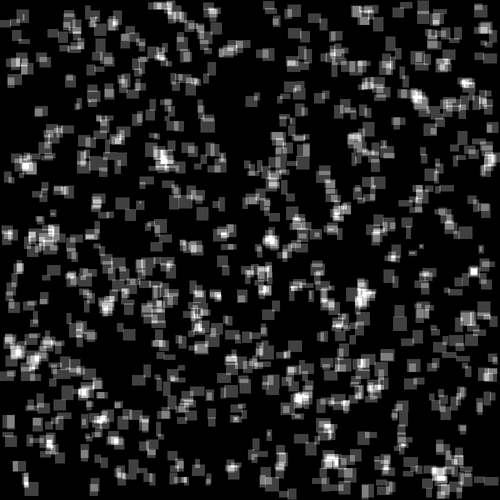

In [24]:
media.set_max_output_height(3000)
_ = day3_part2(puzzle.input, visualize=True)

<a name="day4"></a>
## Day 4: Guard sleep patterns

- Part 1: Find the guard that has the most minutes asleep.  What minute does that guard spend asleep the most?

- Part 2: Which guard is most frequently asleep on the same minute?

In [25]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2018/day/4), `puzzle.input` has 1_028 lines:

[1518-06-25 23:58] Guard #1069 begins shift
[1518-09-16 00:24] falls asleep
[1518-04-06 00:56] wakes up
[1518-11-04 00:48] wakes up
[1518-04-24 00:19] falls asleep
[1518-06-02 23:59] Guard #1697 begins shift
[1518-08-06 00:00] Guard #947 begins shift
[1518-11-01 00:41] falls asleep
 ...
[1518-09-10 23:50] Guard #2039 begins shift
[1518-08-16 23:54] Guard #277 begins shift
[1518-06-10 00:48] wakes up
[1518-09-24 00:47] wakes up


The stored answers are: `{1: '39584', 2: '55053'}`

In [26]:
s1 = """\
[1518-11-01 00:00] Guard #10 begins shift
[1518-11-01 00:05] falls asleep
[1518-11-01 00:25] wakes up
[1518-11-01 00:30] falls asleep
[1518-11-01 00:55] wakes up
[1518-11-01 23:58] Guard #99 begins shift
[1518-11-02 00:40] falls asleep
[1518-11-02 00:50] wakes up
[1518-11-03 00:05] Guard #10 begins shift
[1518-11-03 00:24] falls asleep
[1518-11-03 00:29] wakes up
[1518-11-04 00:02] Guard #99 begins shift
[1518-11-04 00:36] falls asleep
[1518-11-04 00:46] wakes up
[1518-11-05 00:03] Guard #99 begins shift
[1518-11-05 00:45] falls asleep
[1518-11-05 00:55] wakes up
"""

In [27]:
def day4(s, *, part2=False):
  lines = s.splitlines()
  lines = sorted(lines)
  num_dates = sum('Guard' in line for line in lines)
  asleep = np.zeros((num_dates, 60))
  date_guard = np.empty(num_dates, int)
  row = -1
  for line in lines:
    (minute,) = map(int, hh.re_groups(r' \d\d:(\d\d)', line))
    if 'Guard' in line:
      (guard,) = map(int, hh.re_groups(r' Guard #(\d+) begins shift', line))
      row += 1
      date_guard[row] = guard
    elif 'falls asleep' in line:
      asleep_minute = minute
    elif 'wakes up' in line:
      asleep[row][asleep_minute:minute] = 1
    else:
      raise ValueError(line)

  guards = set(date_guard)

  if not part2:
    total_sleep = {guard: asleep[date_guard == guard].sum() for guard in guards}
    guard_most_sleep = max(total_sleep, key=lambda guard: total_sleep[guard])
    minute_sleep = asleep[date_guard == guard_most_sleep].sum(axis=0)
    minute_most_sleep = minute_sleep.argmax()
    return guard_most_sleep * minute_most_sleep

  guard_sleep_by_minute = {guard: asleep[date_guard == guard].sum(axis=0) for guard in guards}
  guard_max_sleep_by_minute = {guard: array.max() for guard, array in guard_sleep_by_minute.items()}
  guard = max(guard_max_sleep_by_minute, key=lambda guard: guard_max_sleep_by_minute[guard])
  minute = guard_sleep_by_minute[guard].argmax()
  return guard * minute


check_eq(day4(s1), 10 * 24)
puzzle.verify(1, day4)

day4_part2 = functools.partial(day4, part2=True)
check_eq(day4_part2(s1), 99 * 45)
puzzle.verify(2, day4_part2)

(Part 1: 0.002 s)
(Part 2: 0.002 s)


<a name="day5"></a>
## Day 5: Polymer string simplification

- Part 1: Find the length of the string after successively removing all 'bB' and 'Cc' letter pairs.

- Part 2: Do the same after allowing all instances of a single letter to be initially removed.

In [28]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2018/day/5), `puzzle.input` has a single line of 50_000 characters:

cgGfFBbCHhxxXBEebrnNRuUMYMmyyYqTtoOQyYmDbBeYdDDdykKENnVvIidztTxXZmcCOoKkSsMxhHqQ ... hHIZziMAamvKkVdTDddpPDNnQqmMXFfYjJy


The stored answers are: `{1: '9386', 2: '4876'}`

In [29]:
def day5a(s, *, part2=False):  # Slow.
  def simplify_polymer(s):
    pairs = [chr(ord('a') + i) + chr(ord('A') + i) for i in range(26)]
    pairs += [chr(ord('A') + i) + chr(ord('a') + i) for i in range(26)]
    regex = re.compile('|'.join(pairs))
    s_old = None
    while s != s_old:
      s_old = s
      s = regex.sub('', s)
    return s

  def remove_elem(s, i):
    return s.replace(chr(ord('A') + i), '').replace(chr(ord('a') + i), '')

  s = s.strip()
  if not part2:
    return len(simplify_polymer(s))

  return min(len(simplify_polymer(remove_elem(s, i))) for i in range(26))


check_eq(day5a('dabAcCaCBAcCcaDA'), 10)
# puzzle.verify(1, day5a)  # Slow.

day5a_part2 = functools.partial(day5a, part2=True)
check_eq(day5a_part2('dabAcCaCBAcCcaDA'), 4)
# puzzle.verify(2, day5a_part2)  # Slow.

In [30]:
# Faster, using stack and numba.
@numba.njit
def day5b_simplify_polymer(s):
  l: list[str] = []
  for ch in s:
    if l and abs(ord(ch) - ord(l[-1])) == 32:
      l.pop()
    else:
      l.append(ch)
  return ''.join(l)


def day5b(s, *, part2=False):
  def remove_elem(s, i):
    return s.replace(chr(ord('A') + i), '').replace(chr(ord('a') + i), '')

  s = s.strip()
  if not part2:
    return len(day5b_simplify_polymer(s))

  return min(len(day5b_simplify_polymer(remove_elem(s, i))) for i in range(26))


check_eq(day5b('dabAcCaCBAcCcaDA'), 10)  # Slow for numba compilation.
puzzle.verify(1, day5b)

day5b_part2 = functools.partial(day5b, part2=True)
check_eq(day5b_part2('dabAcCaCBAcCcaDA'), 4)
puzzle.verify(2, day5b_part2)

(Part 1: 0.002 s)
(Part 2: 0.057 s)


In [31]:
# Fastest; nested loops in numba.
@numba.njit
def day5_length_of_simplified_polymer(codes):
  l: list[int] = []
  for code in codes:
    if l and abs(code - l[-1]) == 32:
      l.pop()
    else:
      l.append(code)
  return len(l)


@numba.njit
def day5_min_length_after_removing_any_one_letter_pair(codes):
  min_length = 10**8
  for omit in range(26):
    l: list[int] = []
    for code in codes:
      if code not in (omit, omit + 32):
        if l and abs(code - l[-1]) == 32:
          l.pop()
        else:
          l.append(code)
    min_length = min(min_length, len(l))
  return min_length


def day5(s, *, part2=False):
  # Convert string to list of codes, each in 0..25 or 32..57 .
  codes = np.array([ord(ch) - ord('A') for ch in s.strip()], np.int32)
  if not part2:
    return day5_length_of_simplified_polymer(codes)

  return day5_min_length_after_removing_any_one_letter_pair(codes)


check_eq(day5('dabAcCaCBAcCcaDA'), 10)
puzzle.verify(1, day5)

day5_part2 = functools.partial(day5, part2=True)
check_eq(day5_part2('dabAcCaCBAcCcaDA'), 4)
puzzle.verify(2, day5_part2)

(Part 1: 0.004 s)
(Part 2: 0.010 s)


<a name="day6"></a>
## Day 6: Voronoi areas

- Part 1: What is the size of the largest area that isn't infinite?

- Part 2: What is the size of the region containing all locations which have a total distance to all given coordinates of less than 10000?

In [32]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2018/day/6), `puzzle.input` has 50 lines:

353, 177
233, 332
178, 231
351, 221
309, 151
105, 289
91, 236
321, 206
 ...
277, 173
286, 44
242, 150
120, 230


The stored answers are: `{1: '4829', 2: '46966'}`

In [33]:
s1 = """\
1, 1
1, 6
8, 3
3, 4
5, 5
8, 9
"""

In [34]:
def day6(s, *, part2=False, max_sum=10_000, visualize=False):
  yxs = []
  for line in s.splitlines():
    x, y = map(int, line.split(','))
    yxs.append((y, x))
  shape = np.max(yxs, axis=0) + 1

  def manhattan_from(yx):
    indices = np.indices(shape, np.int32)
    return abs(indices[0] - yx[0]) + abs(indices[1] - yx[1])

  all_manhattans = np.array([manhattan_from(yx) for yx in yxs])

  if not part2:
    closest = all_manhattans.argmin(axis=0)
    # min_manhattan = all_manhattans.min(axis=0)  # Same but a bit slower.
    min_manhattan = np.take_along_axis(all_manhattans, closest[None], axis=0)[0]
    count_min = np.count_nonzero(all_manhattans == min_manhattan, axis=0)
    closest[count_min > 1] = -1  # Disqualify equidistant locations.
    unbounded = set(closest[0]) | set(closest[-1]) | set(closest[:, 0]) | set(closest[:, -1])
    counts = collections.Counter(closest.flat)
    count, i = max((c, i) for i, c in counts.items() if i not in unbounded | {-1})
    if visualize:
      cmap = np.random.default_rng(0).choice(range(30, 150), (len(yxs) + 1, 3)).astype(np.uint8)
      image = cmap[closest + 1]
      unb = (closest[..., None] == np.array(list(unbounded))).sum(axis=-1) > 0
      image[unb] += 105
      image[closest == -1] = 255, 255, 255
      image2 = image.copy()
      image2[closest == i] = 255, 0, 0
      media.show_video([image, image2], codec='gif', fps=1, title='day06')
    return count

  sum_manhattans = all_manhattans.sum(axis=0)
  if visualize:
    media.show_image(sum_manhattans < max_sum, title=None)
  return np.count_nonzero(sum_manhattans < max_sum)


check_eq(day6(s1), 17)
puzzle.verify(1, day6)

(Part 1: 0.047 s)


day06

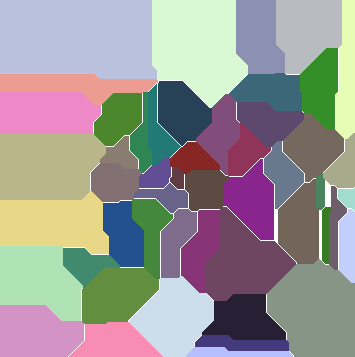

In [35]:
_ = day6(puzzle.input, visualize=True)

In [36]:
day6_part2 = functools.partial(day6, part2=True)
check_eq(day6_part2(s1, max_sum=32), 16)
puzzle.verify(2, day6_part2)

(Part 2: 0.014 s)


""

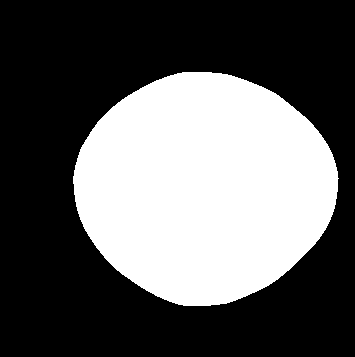

In [37]:
_ = day6_part2(puzzle.input, visualize=True)

<a name="day7"></a>
## Day 7: Tasks with dependencies

- Part 1: In what order should the steps in your instructions be completed?

- Part 2: With 5 workers and the 60+ second step durations described above, how long will it take to complete all of the steps?

In [38]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2018/day/7), `puzzle.input` has 101 lines:

Step H must be finished before step C can begin.
Step R must be finished before step S can begin.
Step F must be finished before step M can begin.
Step S must be finished before step Z can begin.
Step X must be finished before step Z can begin.
Step Q must be finished before step G can begin.
Step M must be finished before step Z can begin.
Step G must be finished before step V can begin.
 ...
Step F must be finished before step C can begin.
Step B must be finished before step L can begin.
Step O must be finished before step T can begin.
Step S must be finished before step O can begin.


The stored answers are: `{1: 'FHMEQGIRSXNWZBCLOTUADJPKVY', 2: '917'}`

In [39]:
s1 = """\
Step C must be finished before step A can begin.
Step C must be finished before step F can begin.
Step A must be finished before step B can begin.
Step A must be finished before step D can begin.
Step B must be finished before step E can begin.
Step D must be finished before step E can begin.
Step F must be finished before step E can begin.
"""

In [40]:
def day7(s, *, part2=False, num_workers=5, cost_base=60):
  dependencies = collections.defaultdict(set)
  nodes = set()
  for line in s.splitlines():
    pattern = r'^Step (.) must be finished before step (.) can begin\.$'
    node1, node2 = hh.re_groups(pattern, line)
    nodes |= {node1, node2}
    dependencies[node2].add(node1)
  nodelist = sorted(nodes)

  def get_next_node():
    for node in nodelist:
      if not dependencies[node]:
        nodelist.remove(node)
        return node
    return None

  def finish_node(node):
    for set_ in dependencies.values():
      set_ -= {node}

  if not part2:
    result = []
    while nodelist:
      node = get_next_node()
      result.append(node)
      finish_node(node)
    return ''.join(result)

  worker_node = [None] * num_workers
  worker_time = [0] * num_workers
  time = 0
  while True:
    for worker in range(num_workers):
      if worker_node[worker]:
        worker_time[worker] -= 1
        if not worker_time[worker]:
          finish_node(worker_node[worker])
          worker_node[worker] = None
    if not nodelist and not any(worker_node):
      break
    for worker in range(num_workers):
      if not worker_node[worker]:
        if node := get_next_node():
          worker_node[worker] = node
          worker_time[worker] = cost_base + 1 + ord(node) - ord('A')
    time += 1
  return time


check_eq(day7(s1), 'CABDFE')
puzzle.verify(1, day7)

day7_part2 = functools.partial(day7, part2=True)
check_eq(day7_part2(s1, num_workers=2, cost_base=0), 15)
puzzle.verify(2, day7_part2)

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day8"></a>
## Day 8: Tree from preorder traversal

- Part 1: What is the sum of all metadata entries?

- Part 2: What is the computed value of the root node?

In [41]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2018/day/8), `puzzle.input` has a single line of 28_186 characters:

7 11 7 2 5 4 3 4 1 5 0 6 7 5 5 8 1 4 1 1 1 1 1 1 9 0 8 4 8 6 4 1 1 3 6 3 3 2 2 1 ... 2 4 6 1 7 4 6 3 6 9 7 7 5 4 6 7 4 2


The stored answers are: `{1: '36027', 2: '23960'}`

In [42]:
def day8(s, *, part2=False):
  @dataclasses.dataclass
  class TreeNode:
    children: list[TreeNode]
    metadatas: list[int]

  values = map(int, s.split())

  def parse_tree():
    node = TreeNode([], [])
    num_children = next(values)
    num_metadatas = next(values)
    for _ in range(num_children):
      node.children.append(parse_tree())
    for _ in range(num_metadatas):
      node.metadatas.append(next(values))
    return node

  tree = parse_tree()
  assert next(values, None) is None

  def sum_metadata(node):
    return sum(sum_metadata(n) for n in node.children) + sum(node.metadatas)

  if not part2:
    return sum_metadata(tree)

  def node_value(node):
    if not node.children:
      return sum(node.metadatas)
    return sum(
        node_value(node.children[child_index - 1])
        for child_index in node.metadatas
        if 1 <= child_index <= len(node.children)
    )

  return node_value(tree)


check_eq(day8('2 3 0 3 10 11 12 1 1 0 1 99 2 1 1 2'), 138)
puzzle.verify(1, day8)

day8_part2 = functools.partial(day8, part2=True)
check_eq(day8_part2('2 3 0 3 10 11 12 1 1 0 1 99 2 1 1 2'), 66)
puzzle.verify(2, day8_part2)

(Part 1: 0.003 s)
(Part 2: 0.003 s)


<a name="day9"></a>
## Day 9: Circle of marbles

- Part 1: What is the winning Elf's score?

- Part 2: What would the new winning Elf's score be if the number of the last marble were 100 times larger?

In [43]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2018/day/9), `puzzle.input` has a single line of 46 characters:

479 players; last marble is worth 71035 points


The stored answers are: `{1: '367634', 2: '3020072891'}`

In [44]:
def day9a(s, *, part2=False):  # Compact.
  pattern = r'^(\d+) players; last marble is worth (\d+) points$'
  num_players, last_marble = map(int, hh.re_groups(pattern, s.strip()))
  if part2:
    last_marble *= 100
  marbles = collections.deque([0])
  scores = [0] * num_players
  for marble in range(1, last_marble + 1):
    if marble % 23 == 0:
      marbles.rotate(7)
      scores[marble % num_players] += marble + marbles.popleft()
    else:
      marbles.rotate(-2)
      marbles.appendleft(marble)

  return max(scores)


check_eq(day9a('10 players; last marble is worth 1618 points'), 8317)
check_eq(day9a('13 players; last marble is worth 7999 points'), 146373)
check_eq(day9a('17 players; last marble is worth 1104 points'), 2764)
check_eq(day9a('21 players; last marble is worth 6111 points'), 54718)
check_eq(day9a('30 players; last marble is worth 5807 points'), 37305)
puzzle.verify(1, day9a)

day9a_part2 = functools.partial(day9a, part2=True)
# puzzle.verify(2, day9a_part2)  # Slow.

(Part 1: 0.006 s)


In [45]:
def day9b(s, *, part2=False):  # Slightly faster with quick inner loop.
  pattern = r'^(\d+) players; last marble is worth (\d+) points$'
  num_players, last_marble = map(int, hh.re_groups(pattern, s.strip()))
  if part2:
    last_marble *= 100
  # Note that numba does not support deque; there is a feature request:
  # https://githubmemory.com/repo/numba/numba/issues/7417
  marbles = collections.deque([0])
  scores = [0] * num_players
  marble = 1
  while marble < last_marble - 23:
    for marble in range(marble, marble + 22):
      marbles.rotate(-1)
      marbles.append(marble)
    marble += 1
    marbles.rotate(7)
    scores[marble % num_players] += marble + marbles.pop()
    marbles.rotate(-1)
    marble += 1

  for marble in range(marble, last_marble + 1):
    if marble % 23 == 0:
      marbles.rotate(7)
      scores[marble % num_players] += marble + marbles.pop()
      marbles.rotate(-1)
    else:
      marbles.rotate(-1)
      marbles.append(marble)

  return max(scores)


check_eq(day9b('10 players; last marble is worth 1618 points'), 8317)
check_eq(day9b('13 players; last marble is worth 7999 points'), 146373)
check_eq(day9b('17 players; last marble is worth 1104 points'), 2764)
check_eq(day9b('21 players; last marble is worth 6111 points'), 54718)
check_eq(day9b('30 players; last marble is worth 5807 points'), 37305)
puzzle.verify(1, day9b)

day9b_part2 = functools.partial(day9b, part2=True)
# puzzle.verify(2, day9b_part2)  # Slow.

(Part 1: 0.005 s)


In [46]:
# Fastest.  Singly-linked list is sufficient!
@numba.njit
def day9_func(num_players: int, last_marble: int) -> int:
  scores = [0] * num_players
  # "array[marble1] == marble2" indicates that marble2 is next after marble1.
  array = np.empty(last_marble + 23, np.int32)
  array[0] = 1
  array[1] = 0
  marble = 2

  while True:
    for marble in range(marble, marble + 21):  # e.g., [2, ..., 22]
      marble1 = array[marble - 1]
      marble2 = array[marble1]
      array[marble1] = marble
      array[marble] = marble2
    marble += 1  # e.g., 23
    popped = array[marble - 5]  # e.g., 9 = next(18)
    if marble > last_marble:
      break
    scores[marble % num_players] += marble + popped
    array[marble - 5] = marble - 4  # Remove popped.
    next19 = array[marble - 4]
    array[marble + 1] = array[next19]  # e.g., next(24) = next(next(19))
    array[next19] = marble + 1  # e.g., next(next(19)) = 24
    marble += 2  # e.g., 25 == 2 (mod 23)

  return max(scores)


def day9(s, *, part2=False):
  pattern = r'^(\d+) players; last marble is worth (\d+) points$'
  num_players, last_marble = map(int, hh.re_groups(pattern, s.strip()))
  if part2:
    last_marble *= 100
  return day9_func(num_players, last_marble)


check_eq(day9('10 players; last marble is worth 1618 points'), 8317)
check_eq(day9('13 players; last marble is worth 7999 points'), 146373)
check_eq(day9('17 players; last marble is worth 1104 points'), 2764)
check_eq(day9('21 players; last marble is worth 6111 points'), 54718)
check_eq(day9('30 players; last marble is worth 5807 points'), 37305)
puzzle.verify(1, day9)

day9_part2 = functools.partial(day9, part2=True)
_ = day9_part2(puzzle.input)  # For numba compilation.
puzzle.verify(2, day9_part2)

(Part 1: 0.000 s)
(Part 2: 0.017 s)


<a name="day10"></a>
## Day 10: Message from moving points

- Part 1: What message will eventually appear in the sky?

- Part 2: how many seconds would they have needed to wait for that message to appear?

In [47]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2018/day/10), `puzzle.input` has 383 lines:

position=< 20247,  40241> velocity=<-2, -4>
position=< 10184, -29948> velocity=<-1,  3>
position=< 50313, -39966> velocity=<-5,  4>
position=<-19870, -19921> velocity=< 2,  2>
position=< 10224, -49995> velocity=<-1,  5>
position=<-19904,  20191> velocity=< 2, -2>
position=< 50300,  -9887> velocity=<-5,  1>
position=<-29924, -29942> velocity=< 3,  3>
 ...
position=< -9838,  30214> velocity=< 1, -3>
position=< 50305,  50269> velocity=<-5, -5>
position=<-49933,  -9891> velocity=< 5,  1>
position=< 50321,  30215> velocity=<-5, -3>


The stored answers are: `{1: 'FPRBRRZA', 2: '10027'}`

In [48]:
s1 = """\
position=< 9,  1> velocity=< 0,  2>
position=< 7,  0> velocity=<-1,  0>
position=< 3, -2> velocity=<-1,  1>
position=< 6, 10> velocity=<-2, -1>
position=< 2, -4> velocity=< 2,  2>
position=<-6, 10> velocity=< 2, -2>
position=< 1,  8> velocity=< 1, -1>
position=< 1,  7> velocity=< 1,  0>
position=<-3, 11> velocity=< 1, -2>
position=< 7,  6> velocity=<-1, -1>
position=<-2,  3> velocity=< 1,  0>
position=<-4,  3> velocity=< 2,  0>
position=<10, -3> velocity=<-1,  1>
position=< 5, 11> velocity=< 1, -2>
position=< 4,  7> velocity=< 0, -1>
position=< 8, -2> velocity=< 0,  1>
position=<15,  0> velocity=<-2,  0>
position=< 1,  6> velocity=< 1,  0>
position=< 8,  9> velocity=< 0, -1>
position=< 3,  3> velocity=<-1,  1>
position=< 0,  5> velocity=< 0, -1>
position=<-2,  2> velocity=< 2,  0>
position=< 5, -2> velocity=< 1,  2>
position=< 1,  4> velocity=< 2,  1>
position=<-2,  7> velocity=< 2, -2>
position=< 3,  6> velocity=<-1, -1>
position=< 5,  0> velocity=< 1,  0>
position=<-6,  0> velocity=< 2,  0>
position=< 5,  9> velocity=< 1, -2>
position=<14,  7> velocity=<-2,  0>
position=<-3,  6> velocity=< 2, -1>
"""

In [49]:
# "Support for 10-pixel-tall characters (2018 Day 10) is coming soon."
if 0:  # https://pypi.org/project/advent-of-code-ocr/
  hh.run('!pip -q install advent-of-code-ocr')
  # import advent_of_code_ocr

In [50]:
def day10a(s, *, part2=False):  # Slow.
  positions0, velocities0 = [], []
  for line in s.splitlines():
    pattern = r'^position=< *(\S+), *(\S+)> velocity=< *(\S+), *(\S+)>$'
    x, y, dx, dy = map(int, hh.re_groups(pattern, line))
    positions0.append([y, x])
    velocities0.append([dy, dx])
  positions, velocities = np.array(positions0), np.array(velocities0)

  for index in itertools.count():
    shape = positions.ptp(axis=0) + 1
    if shape[0] == 8 or (shape[0] == 10 and shape[1] > 30):
      break
    positions += velocities

  if part2:
    return index

  grid = hh.grid_from_indices(positions, dtype=np.uint8)
  hashed = hashlib.md5(''.join(map(str, grid.flat)).encode()).hexdigest()
  # print(hashed)
  if shape[1] <= 30:
    return 'HI'
  return {
      '05d005c2fd38c74568ab697305825ff6': 'FPRBRRZA',  # google.Hugues_Hoppe.965276
      '7a115ac723c75059c742c8bb21d5ee1c': 'ERCXLAJL',  # github.hhoppe.1452460
  }[hashed]


check_eq(day10a(s1), 'HI')
puzzle.verify(1, day10a)

day10a_part2 = functools.partial(day10a, part2=True)
check_eq(day10a_part2(s1), 3)
puzzle.verify(2, day10a_part2)

(Part 1: 0.143 s)
(Part 2: 0.137 s)


In [51]:
def day10(s, *, part2=False, visualize=False):  # Quick initial jump; visualize.
  positions0, velocities0 = [], []
  for line in s.splitlines():
    pattern = r'^position=< *(\S+), *(\S+)> velocity=< *(\S+), *(\S+)>$'
    x, y, dx, dy = map(int, hh.re_groups(pattern, line))
    positions0.append([y, x])
    velocities0.append([dy, dx])
  positions, velocities = np.array(positions0), np.array(velocities0)
  all_positions = []

  leftmost, rightmost = positions[:, 1].argmin(), positions[:, 1].argmax()
  index = (positions[rightmost, 1] - positions[leftmost, 1]) // abs(
      velocities[leftmost, 1] - velocities[rightmost, 1]
  )
  index = max(index - 20, 0)
  positions += velocities * index

  while True:
    if visualize:
      all_positions.extend([(index, y, x) for y, x in positions])
    shape = positions.ptp(axis=0) + 1
    if shape[0] == 8 or (shape[0] == 10 and shape[1] > 30):
      break
    positions += velocities
    index += 1

  if part2:
    return index

  grid = hh.grid_from_indices(positions, dtype=np.uint8)
  if visualize:
    image = np.pad(grid, 1).repeat(4, axis=0).repeat(4, axis=1)
    media.show_image(image, border=True, title=None)
    video: Any = hh.grid_from_indices(all_positions, dtype=float)
    video = [video[0]] * 5 + list(video) + [video[-1]] * 10
    media.show_video(video, codec='gif', fps=5, title='day10')
  hashed = hashlib.md5(''.join(map(str, grid.flat)).encode()).hexdigest()
  # print(hashed)
  if shape[1] <= 30:
    return 'HI'
  return {
      '05d005c2fd38c74568ab697305825ff6': 'FPRBRRZA',  # google.Hugues_Hoppe.965276
      '7a115ac723c75059c742c8bb21d5ee1c': 'ERCXLAJL',  # github.hhoppe.1452460
  }[hashed]


check_eq(day10(s1), 'HI')
puzzle.verify(1, day10)

day10_part2 = functools.partial(day10, part2=True)
check_eq(day10_part2(s1), 3)
puzzle.verify(2, day10_part2)

(Part 1: 0.002 s)
(Part 2: 0.001 s)


""

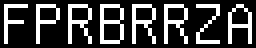

day10

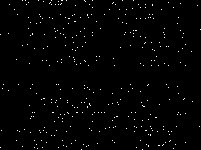

In [52]:
_ = day10(puzzle.input, visualize=True)

<a name="day11"></a>
## Day 11: Grid square with largest sum

- Part 1: What is the `X,Y` coordinate of the top-left fuel cell of the 3x3 square with the largest total power?

- Part 2: What is the `X,Y,size` identifier of the square with the largest total power?

In [53]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2018/day/11), `puzzle.input` has a single line of 4 characters:

9005


The stored answers are: `{1: '20,32', 2: '235,287,13'}`

In [54]:
def day11(s, *, part2=False, visualize=False):
  def power_level(yx, serial_number):
    rack_id = yx[1] + 10
    return ((rack_id * yx[0] + serial_number) * rack_id // 100) % 10 - 5

  check_eq(power_level([5, 3], serial_number=8), 4)
  check_eq(power_level([79, 122], serial_number=57), -5)
  check_eq(power_level([196, 217], serial_number=39), 0)
  check_eq(power_level([153, 101], serial_number=71), 4)

  serial_number = int(s)
  indices = np.indices((300, 300), np.int32)
  power = power_level(indices + 1, serial_number=serial_number)
  integral = np.pad(power, [[1, 0], [1, 0]]).cumsum(axis=0).cumsum(axis=1)

  def get_yx_largest(size):
    if 0:  # Slower.
      box = np.full((size, size), 1, np.int32)
      result = scipy.signal.convolve2d(power, box, mode='valid')
    else:
      result = (
          integral[size:, size:]
          - integral[size:, :-size]
          - integral[:-size, size:]
          + integral[:-size, :-size]
      )
    yx_largest = np.unravel_index(result.argmax(), result.shape)
    return yx_largest, result[yx_largest]

  if not part2:
    yx_largest = get_yx_largest(size=3)[0]
    return f'{yx_largest[1] + 1},{yx_largest[0] + 1}'

  results = {size: get_yx_largest(size) for size in range(1, 301)}
  best_size = max(results, key=lambda size: results[size][1])
  yx_largest, _ = results[best_size]

  if visualize:
    image = media.to_rgb(power * 1.0, cmap='bwr')
    image2 = image.copy()
    image2[
        yx_largest[0] : yx_largest[0] + best_size, yx_largest[1] : yx_largest[1] + best_size
    ] *= 0.7
    image = image.repeat(2, axis=0).repeat(2, axis=1)
    image2 = image2.repeat(2, axis=0).repeat(2, axis=1)
    media.show_video([image, image2], codec='gif', fps=1, title='day11')

  return f'{yx_largest[1] + 1},{yx_largest[0] + 1},{best_size}'


check_eq(day11('18'), '33,45')
check_eq(day11('42'), '21,61')
puzzle.verify(1, day11)

day11_part2 = functools.partial(day11, part2=True)
check_eq(day11_part2('18'), '90,269,16')
check_eq(day11_part2('42'), '232,251,12')
puzzle.verify(2, day11_part2)

(Part 1: 0.001 s)
(Part 2: 0.020 s)


day11

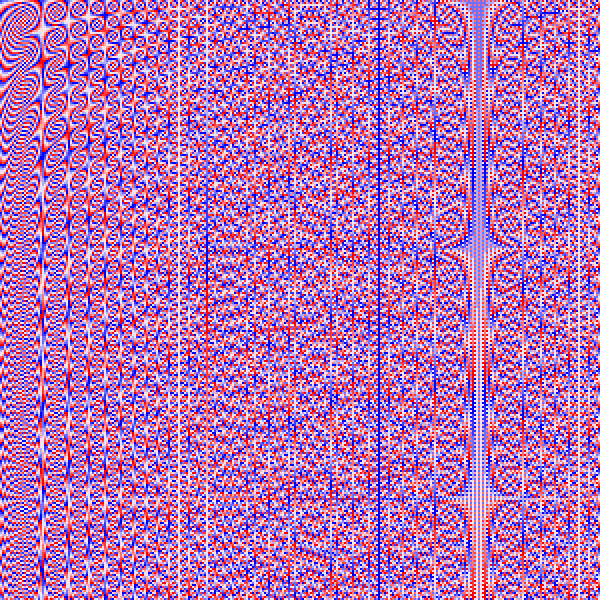

In [55]:
_ = day11_part2(puzzle.input, visualize=True)

The blinking (darkened) region at the lower-right indicates the square
with the largest sum of values in the image.
(Blue indicates small values; red indicates large values.)

<a name="day12"></a>
## Day 12: Cellular automaton in 1D

- Part 1: After 20 generations, what is the sum of the numbers of all pots which contain a plant?

- Part 2: After fifty billion (50000000000) generations, what is the sum of the numbers of all pots which contain a plant?

In [56]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2018/day/12), `puzzle.input` has 34 lines:

initial state: ###.#..#..##.##.###.#.....#.#.###.#.####....#.##..#.#.#..#....##..#.##...#.###.#.#..#..####.#.##.#

#.... => .
#.##. => #
..#.. => .
#.#.# => .
.#.## => #
...## => #
 ...
.#..# => #
.#### => .
##### => #
##.## => #


The stored answers are: `{1: '2909', 2: '2500000001175'}`

In [57]:
s1 = """\
initial state: #..#.#..##......###...###

...## => #
..#.. => #
.#... => #
.#.#. => #
.#.## => #
.##.. => #
.#### => #
#.#.# => #
#.### => #
##.#. => #
##.## => #
###.. => #
###.# => #
####. => #
"""

In [58]:
def day12(s, *, part2=False, visualize=False):
  lines = s.splitlines()
  assert lines[0].startswith('initial state: ') and not lines[1]
  state = lines[0][15:]
  rules = {''.join(key): '.' for key in itertools.product('.#', repeat=5)}
  for line in lines[2:]:
    key, value = line.split(' => ')
    rules[key] = value
  states = [state]

  def sum_pots(state, pad_len):
    return sum(i - pad_len for i, ch in enumerate(state) if ch == '#')

  for index in range(10**8 if part2 else 20):
    # Grown the domain by two extra '.' on both sides.
    state = '....' + state + '....'
    state = ''.join(rules[''.join(w)] for w in more_itertools.sliding_window(state, 5))
    states.append(state)
    if part2 and len(states) >= 2:
      if any(
          states[-2] == states[-1][2 + shift : 2 + shift + len(states[-2])] for shift in (-1, 0, 1)
      ):
        break

  if visualize:
    padded_states = []
    for index, state in enumerate(states):
      pad_len = (len(states) - 1 - index) * 2
      padded_states.append('.' * pad_len + state + '.' * pad_len)
    grid = np.array([list(state) for state in padded_states]) == '#'
    xmin, xmax = np.nonzero(grid.any(axis=0))[0][[0, -1]]
    grid = grid[:, max(xmin - 4, 0) : xmax + 5]
    grid = grid.repeat(2, axis=0).repeat(2, axis=1)
    media.show_image(grid, title='day12')

  if not part2:
    return sum_pots(states[-1], pad_len=2 * (len(states) - 1))

  sum_pots2 = sum_pots(states[-1], pad_len=2 * (len(states) - 1))
  sum_pots1 = sum_pots(states[-2], pad_len=2 * (len(states) - 2))
  diff_sum_pots = sum_pots2 - sum_pots1
  remaining_generations = 50000000000 - (len(states) - 1)
  return sum_pots2 + diff_sum_pots * remaining_generations


check_eq(day12(s1), 325)
puzzle.verify(1, day12)

day12_part2 = functools.partial(day12, part2=True)
puzzle.verify(2, day12_part2)

(Part 1: 0.001 s)
(Part 2: 0.006 s)


day12

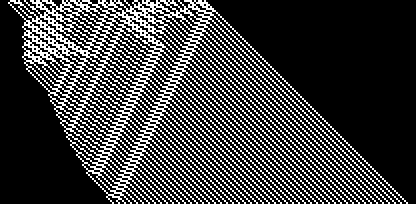

In [59]:
_ = day12_part2(puzzle.input, visualize=True)

For my input, after 102 generations, the output has converged to a constant pattern that is translating rightward by 1 space every generation.


<a name="day13"></a>
## Day 13: Carts on tracks

- Part 1: What is the `x,y` location of the first crash?

- Part 2: What is the location of the last cart at the end of the first tick where it is the only cart left?

In [60]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2018/day/13), `puzzle.input` has 150 lines:

                                  /----------------------------\                 ...                                    
  /-------------------------------+----------------------------+---------------- ...                                    
  |                               |                            |                 ... ---------------------\             
  |               /---------------+----------------------------+---------------- ...                      |             
  |  /------------+------------\  |                            |                 ... ---------------\     |             
  |  |            |            |  |                            |                 ...          /-----+---\ |             
  |  |        /---+------------+--+-------------------------\  |/--------------- ...          |     |   | |             
  |  |        |   |        /---+--+-------------------------+--++--------------- ... --\      |  /--+---+-+------\      
 ...
           |       \---+---

The stored answers are: `{1: '80,100', 2: '16,99'}`

In [61]:
s1 = r"""
/->-\        EOL
|   |  /----\EOL
| /-+--+-\  |EOL
| | |  | v  |EOL
\-+-/  \-+--/EOL
  \------/   EOL
"""[
    1:
].replace(
    'EOL', ''
)

s2 = r"""
/>-<\  EOL
|   |  EOL
| /<+-\EOL
| | | vEOL
\>+</ |EOL
  |   ^EOL
  \<->/EOL
"""[
    1:
].replace(
    'EOL', ''
)

In [76]:
def day13(s, *, part2=False, verbose=False, visualize=False):
  @dataclasses.dataclass
  class Cart:
    yx: tuple[int, int]
    direction: str  # '<', '>', 'v', or '^'.
    next_turn: int = 0  # Three states: 0=left, 1=straight, 2=right.

  grid = hh.grid_from_string(s)
  carts = []
  for ch in '<>v^':
    for yx in map(tuple, np.argwhere(grid == ch)):
      grid[yx] = {'<': '-', '>': '-', 'v': '|', '^': '|'}[ch]
      carts.append(Cart(yx, ch))  # type: ignore[arg-type]

  def text_from_grid():
    grid2 = grid.copy()
    for cart in carts:
      grid2[cart.yx] = cart.direction
    return hh.string_from_grid(grid2)

  check_eq(text_from_grid(), s.rstrip('\n'))

  if visualize:
    cmap = {' ': (250,) * 3, '+': (140, 140, 140)} | {ch: (180,) * 3 for ch in r'|-\/'}
    image0 = np.array([cmap[e] for e in grid.flat], np.uint8).reshape(*grid.shape, 3)

  images = []
  for iteration in itertools.count():
    assert len(carts) >= 2
    if visualize:
      image = image0.copy()
      for cart in carts:
        image[cart.yx] = 0, 100, 0
      images.append(image)
    if verbose:
      print(text_from_grid())
    for cart in sorted(carts, key=lambda cart: cart.yx):
      if cart.yx[0] == -1:
        continue
      dyx = {'<': (0, -1), '>': (0, 1), '^': (-1, 0), 'v': (1, 0)}[cart.direction]
      # new_yx = tuple(np.array(cart.yx) + dyx)
      new_yx = cart.yx[0] + dyx[0], cart.yx[1] + dyx[1]
      cart2 = next((cart2 for cart2 in carts if cart2.yx == new_yx), None)
      if cart2:  # Collison.
        if not part2:
          if visualize:
            image = image.copy()
            image[new_yx] = 255, 0, 0
            images.append(image)
            images = [im.repeat(3, axis=0).repeat(3, axis=1) for im in images]
            images = [images[0]] * 20 + images + [images[-1]] * 40
            media.show_video(images, codec='gif', fps=20, title='day13')
            return None
          if 0:
            print(f'first collision at {iteration=}')
          return f'{new_yx[1]},{new_yx[0]}'
        for crashed_cart in [cart, cart2]:
          crashed_cart.yx = -1, -1
        continue
      ch = grid[new_yx]
      match ch:
        case '/' | '\\':
          cart.direction = {
              '</': 'v',
              '<\\': '^',
              '>/': '^',
              '>\\': 'v',
              '^/': '>',
              '^\\': '<',
              'v/': '<',
              'v\\': '>',
          }[cart.direction + ch]
        case '+':
          if cart.next_turn in (0, 2):
            cart.direction = {
                '<0': 'v',
                '<2': '^',
                '>0': '^',
                '>2': 'v',
                '^0': '<',
                '^2': '>',
                'v0': '>',
                'v2': '<',
            }[cart.direction + str(cart.next_turn)]
          cart.next_turn = (cart.next_turn + 1) % 3
        case '-' | '|':
          pass
        case _:
          raise ValueError(ch)
      cart.yx = new_yx
    carts = [cart for cart in carts if cart.yx[0] != -1]
    if part2 and len(carts) == 1:
      if 0:
        print(f'Only one cart left at {iteration=}')
      return f'{carts[0].yx[1]},{carts[0].yx[0]}'


check_eq(day13(s1), '7,3')
puzzle.verify(1, day13)

(Part 1: 0.008 s)


day13

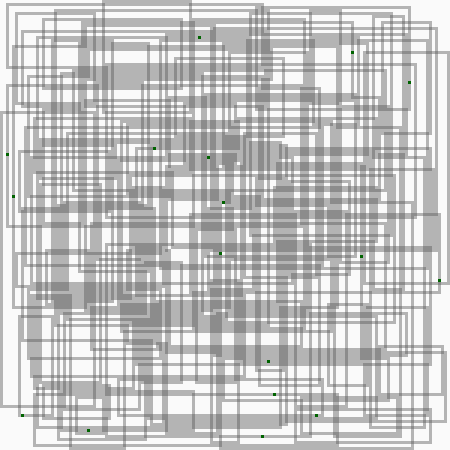

In [77]:
_ = day13(puzzle.input, visualize=True)  # Slow; ~1 s.

In [78]:
day13_part2 = functools.partial(day13, part2=True)
check_eq(day13_part2(s2), '6,4')
puzzle.verify(2, day13_part2)

(Part 2: 0.104 s)


<a name="day14"></a>
## Day 14: Combining recipes

- Part 1: What are the scores of the ten recipes immediately after the number of recipes in your puzzle input?

- Part 2: How many recipes appear on the scoreboard to the left of the score sequence in your puzzle input?

In [79]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2018/day/14), `puzzle.input` has a single line of 6 characters:

702831


The stored answers are: `{1: '1132413111', 2: '20340232'}`

In [80]:
def day14a_part1(s):  # Slow.
  num_recipes = int(s)
  recipes = [3, 7]
  indices = [0, 1]

  while len(recipes) < num_recipes + 10:
    currents = [recipes[index] for index in indices]
    total = sum(currents)
    digits = [1, total - 10] if total >= 10 else [total]
    recipes.extend(digits)
    indices = [(index + 1 + recipes[index]) % len(recipes) for index in indices]

  return ''.join(map(str, recipes[num_recipes : num_recipes + 10]))


check_eq(day14a_part1('9'), '5158916779')
check_eq(day14a_part1('5'), '0124515891')
check_eq(day14a_part1('18'), '9251071085')
check_eq(day14a_part1('2018'), '5941429882')
puzzle.verify(1, day14a_part1)

(Part 1: 0.305 s)


In [81]:
# Fast Part 1 using numba.
@numba.njit
def day14_part1_func(num_recipes: int) -> np.ndarray:
  recipes = np.full(num_recipes + 11, 1, np.uint8)
  num = 2
  recipes[0] = 3
  recipes[1] = 7
  index0, index1 = 0, 1
  while num < num_recipes + 10:
    current0, current1 = recipes[index0], recipes[index1]
    total = current0 + current1
    if total >= 10:
      recipes[num + 1] = total - 10
      num += 2
    else:
      recipes[num] = total
      num += 1
    index0 += 1 + current0
    if index0 >= num:
      index0 %= num
    index1 += 1 + current1
    if index1 >= num:
      index1 %= num
  return recipes[num_recipes : num_recipes + 10]


def day14_part1(s):
  num_recipes = int(s)
  return ''.join(map(str, day14_part1_func(num_recipes)))


check_eq(day14_part1('9'), '5158916779')
check_eq(day14_part1('5'), '0124515891')
check_eq(day14_part1('18'), '9251071085')
check_eq(day14_part1('2018'), '5941429882')
puzzle.verify(1, day14_part1)

(Part 1: 0.002 s)


In [82]:
def day14a_part2(s):  # Slow.
  pattern = list(map(int, s.strip()))
  recipes = [3, 7]
  indices = [0, 1]

  while True:
    currents = [recipes[index] for index in indices]
    total = sum(currents)
    digits = [1, total - 10] if total >= 10 else [total]
    for digit in digits:
      recipes.append(digit)
      if recipes[-len(pattern) :] == pattern:
        return len(recipes) - len(pattern)
    indices = [(index + 1 + recipes[index]) % len(recipes) for index in indices]


check_eq(day14a_part2('92510'), 18)
check_eq(day14a_part2('59414'), 2018)
# puzzle.verify(2, day14a_part2)  # Slow.

In [83]:
# Fast Part 2 using numba.
@numba.njit
def day14b_part2_func(pattern):
  len_pattern = len(pattern)
  max_recipes = 100_000_000
  recipes = np.empty(max_recipes, np.uint8)
  num = 2
  recipes[0] = 3
  recipes[1] = 7
  index0, index1 = 0, 1

  def matches():
    if num < len_pattern:
      return False
    for i in range(len_pattern):
      if recipes[num - len_pattern + i] != pattern[i]:
        return False
    return True

  while True:
    assert num + 2 < max_recipes
    current0, current1 = recipes[index0], recipes[index1]
    total = current0 + current1
    if total >= 10:
      recipes[num] = 1
      num += 1
      if matches():
        break
      recipes[num] = total - 10
      num += 1
      if matches():
        break
    else:
      recipes[num] = total
      num += 1
      if matches():
        break
    index0 = (index0 + 1 + current0) % num
    index1 = (index1 + 1 + current1) % num
  return num - len_pattern


def day14b_part2(s):
  pattern = np.array(list(s.strip()), np.uint8)
  return day14b_part2_func(pattern)


check_eq(day14b_part2('51589'), 9)
check_eq(day14b_part2('01245'), 5)
check_eq(day14b_part2('92510'), 18)
check_eq(day14b_part2('59414'), 2018)
puzzle.verify(2, day14b_part2)

(Part 2: 0.135 s)


In [84]:
# Faster by generating batches.
@numba.njit
def day14c_part2_func(pattern: np.ndarray) -> int:
  max_recipes = 100_000_000
  recipes = np.empty(max_recipes, np.uint8)
  num = 2
  recipes[0] = 3
  recipes[1] = 7
  index0, index1 = 0, 1
  batch_size = 1000

  while True:
    assert num + batch_size * 2 < max_recipes
    prev_num = max(num - len(pattern) + 1, 0)

    # Generate batch.
    for _ in range(batch_size):
      current0, current1 = recipes[index0], recipes[index1]
      total = current0 + current1
      if total >= 10:
        recipes[num] = 1
        recipes[num + 1] = total - 10
        num += 2
      else:
        recipes[num] = total
        num += 1
      index0 += 1 + current0
      if index0 >= num:
        index0 %= num
      index1 += 1 + current1
      if index1 >= num:
        index1 %= num

    # Find pattern in new batch results.
    sequence = recipes[prev_num:num]
    n = len(sequence)
    m = len(pattern)
    for i in range(n - m + 1):
      for j in range(m):
        if sequence[i + j] != pattern[j]:
          break
      else:
        return prev_num + i


def day14c_part2(s):
  pattern = np.array(list(s.strip()), np.uint8)
  return day14c_part2_func(pattern)


check_eq(day14c_part2('51589'), 9)
check_eq(day14c_part2('01245'), 5)
check_eq(day14c_part2('92510'), 18)
check_eq(day14c_part2('59414'), 2018)
puzzle.verify(2, day14c_part2)

(Part 2: 0.093 s)


In [85]:
# Try using Knuth-Morris-Pratt (KMP); not a win for 6-subseq.
@numba.njit
def day14d_part2_func(pattern: np.ndarray) -> int:
  # Precompute offsets for Knuth-Morris-Pratt (KMP) subsequence search; see
  # https://www.py4u.net/discuss/12693.
  def kmp_offsets(subseq):
    m = len(subseq)
    offsets = np.zeros(m, np.int64)
    j = 1
    k = 0
    while j < m:
      if subseq[j] == subseq[k]:
        k += 1
        offsets[j] = k
        j += 1
      else:
        if k != 0:
          k = offsets[k - 1]
        else:
          offsets[j] = 0
          j += 1
    return offsets

  max_recipes = 100_000_000
  recipes = np.empty(max_recipes, np.uint8)
  num = 2
  recipes[0] = 3
  recipes[1] = 7
  index0, index1 = 0, 1
  batch_size = 1000
  offsets = kmp_offsets(pattern)

  while True:
    assert num + batch_size * 2 < max_recipes
    prev_num = max(num - len(pattern) + 1, 0)

    # Generate batch.
    for _ in range(batch_size):
      current0, current1 = recipes[index0], recipes[index1]
      total = current0 + current1
      if total >= 10:
        recipes[num] = 1
        recipes[num + 1] = total - 10
        num += 2
      else:
        recipes[num] = total
        num += 1
      index0 += 1 + current0
      if index0 >= num:
        index0 %= num
      index1 += 1 + current1
      if index1 >= num:
        index1 %= num

    # Find pattern in new batch results using KMP.
    seq = recipes[prev_num:num]
    subseq = pattern
    m = len(subseq)
    n = len(seq)
    i = j = 0
    while i < n:
      if seq[i] == subseq[j]:
        i += 1
        j += 1
      if j == m:
        return prev_num + (i - j)
      if i < n and seq[i] != subseq[j]:
        if j != 0:
          j = offsets[j - 1]
        else:
          i += 1


def day14d_part2(s):
  pattern = np.array(list(s.strip()), np.uint8)
  return day14d_part2_func(pattern)


check_eq(day14d_part2('51589'), 9)
check_eq(day14d_part2('01245'), 5)
check_eq(day14d_part2('92510'), 18)
check_eq(day14d_part2('59414'), 2018)
puzzle.verify(2, day14d_part2)  # Slower than naive algorithm.

(Part 2: 0.118 s)


In [86]:
# Fastest, using Boyer-Moore-Horspool subsequence search.
@numba.njit
def day14_part2_func(pattern: np.ndarray) -> int:
  max_recipes = 100_000_000
  recipes = np.empty(max_recipes, np.uint8)
  num = 2
  recipes[:num] = 3, 7
  index0, index1 = 0, 1
  batch_size = 1000

  while True:
    assert num + batch_size * 2 < max_recipes
    prev_num = max(num - len(pattern) + 1, 0)

    # Generate batch.
    for _ in range(batch_size):
      current0, current1 = recipes[index0], recipes[index1]
      total = current0 + current1
      if total >= 10:
        recipes[num] = 1
        recipes[num + 1] = total - 10
        num += 2
      else:
        recipes[num] = total
        num += 1
      index0 += 1 + current0
      if index0 >= num:
        index0 %= num
      index1 += 1 + current1
      if index1 >= num:
        index1 %= num

    i = hh.boyer_subsequence_find(recipes[prev_num:num], pattern)
    if i >= 0:
      return prev_num + i


def day14_part2(s):
  pattern = np.array(list(s.strip()), np.uint8)
  return day14_part2_func(pattern)


check_eq(day14_part2('51589'), 9)
check_eq(day14_part2('01245'), 5)
check_eq(day14_part2('92510'), 18)
check_eq(day14_part2('59414'), 2018)
puzzle.verify(2, day14_part2)

(Part 2: 0.081 s)


<a name="day15"></a>
## Day 15: Combat simulation

- Part 1: What is the outcome of the combat described in your puzzle input?

- Part 2: After increasing the Elves' attack power until it is just barely enough for them to win without any Elves dying, what is the outcome of the combat described in your puzzle input?

In [87]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2018/day/15), `puzzle.input` has 32 lines:

################################
#########.######################
#########..#####################
#########..G####################
########....#GG#################
########G......#################
########........################
###.####...#....################
 ...
####...###..#..#######.......###
####...###############.#########
#####..#########################
################################


The stored answers are: `{1: '269430', 2: '55160'}`

In [88]:
s1 = """\
#######
#.G...#
#...EG#
#.#.#G#
#..G#E#
#.....#
#######
"""

s10 = """\
#######
#G..#E#
#E#E.E#
#G.##.#
#...#E#
#...E.#
#######
"""

s11 = """\
#######
#E..EG#
#.#G.E#
#E.##E#
#G..#.#
#..E#.#
#######
"""

s12 = """\
#######
#E.G#.#
#.#G..#
#G.#.G#
#G..#.#
#...E.#
#######
"""

s13 = """\
#######
#.E...#
#.#..G#
#.###.#
#E#G#G#
#...#G#
#######
"""

s14 = """\
#########
#G......#
#.E.#...#
#..##..G#
#...##..#
#...#...#
#.G...G.#
#.....G.#
#########
"""

In [89]:
def day15a_part1(s, verbose=False, elf_attack_power=3, fail_if_elf_dies=False):
  @dataclasses.dataclass
  class Unit:
    yx: tuple[int, int]
    ch: str  # 'E' (Elf) or 'G' (Goblin).
    hit_points: int = 200

  show = hh.show if verbose else lambda *a, **k: None
  grid = hh.grid_from_string(s)
  units = [Unit((y, x), ch) for ch in 'GE' for y, x in np.argwhere(grid == ch)]

  def get_opponents(unit):
    return (u for u in units if u.ch != unit.ch)

  def manhattan(yx1, yx2):
    return abs(yx1[0] - yx2[0]) + abs(yx1[1] - yx2[1])

  def get_adjacent_opponents(unit):
    return [u for u in get_opponents(unit) if manhattan(u.yx, unit.yx) == 1]

  def empty_adjacent_yxs(yx):
    y, x = yx
    for yx2 in ((y - 1, x), (y, x - 1), (y, x + 1), (y + 1, x)):
      # Bounds checking is unnecessary because maze is surrounded by walls.
      if grid[yx2] == '.':
        yield yx2

  def adjacent_towards_opponent(inrange):
    # BFS from unit until yx in inrange; record all others at same distance.
    next_queue = [unit.yx]
    visited: set[tuple[int, int]] = set()
    nearests: set[tuple[int, int]] = set()
    for nearest_distance in itertools.count():
      if nearests or not next_queue:
        break
      queue, next_queue = next_queue, []
      for yx in queue:
        for yx2 in empty_adjacent_yxs(yx):
          if yx2 not in visited:
            visited.add(yx2)
            next_queue.append(yx2)
            if yx2 in inrange:
              nearests.add(yx2)
    if not nearests:
      return None  # No path to opponent.
    nearest = min(nearests)

    # BFS from nearest to unit; find unit neighbor with shortest distance.
    next_queue = [nearest]
    distances = {nearest: 0}
    for distance in range(nearest_distance - 1):
      queue, next_queue = next_queue, []
      for yx in queue:
        for yx2 in empty_adjacent_yxs(yx):
          if yx2 not in distances:
            if distance + manhattan(yx2, unit.yx) <= nearest_distance:  # A*
              distances[yx2] = distance + 1
              next_queue.append(yx2)
    return min(empty_adjacent_yxs(unit.yx), key=lambda yx: (distances.get(yx, math.inf), yx))

  for round in itertools.count():
    hit_points = [u.hit_points for u in sorted(units, key=lambda u: u.yx)]
    show('\nBegin round', round, hit_points)
    # show('' + hh.string_from_grid(grid))
    incomplete_round = False
    for unit in sorted(units, key=lambda unit: unit.yx):
      if unit not in units:  # If already deleted, skip it.
        continue
      if len(set(u.ch for u in units)) == 1:
        incomplete_round = True  # Unit cannot attack, so end of combat.
        break

      # Find nearest attacker-adjacent position and try to move towards it.
      adjacent_opponents = get_adjacent_opponents(unit)
      if not adjacent_opponents:
        inrange = {yx for u in get_opponents(unit) for yx in empty_adjacent_yxs(u.yx)}
        if not inrange:  # No accessible opponent.
          continue
        best_adjacent = adjacent_towards_opponent(inrange)
        if best_adjacent is None:
          continue
        check_eq(grid[unit.yx], unit.ch)
        check_eq(grid[best_adjacent], '.')
        check_eq(manhattan(best_adjacent, unit.yx), 1)
        grid[unit.yx] = '.'
        grid[best_adjacent] = unit.ch
        unit.yx = best_adjacent
        adjacent_opponents = get_adjacent_opponents(unit)

      # Find adjacent opponent with lowest hit points and attack it.
      if adjacent_opponents:
        opponent = min(adjacent_opponents, key=lambda u: (u.hit_points, u.yx))
        attack_power = elf_attack_power if unit.ch == 'E' else 3
        opponent.hit_points -= attack_power
        if opponent.hit_points <= 0:
          check_eq(grid[opponent.yx], opponent.ch)
          grid[opponent.yx] = '.'
          units.remove(opponent)
          if fail_if_elf_dies and opponent.ch == 'E':
            return None
    if incomplete_round:
      break

  num_rounds = round
  hit_points = [u.hit_points for u in sorted(units, key=lambda u: u.yx)]
  sum_points = sum(hit_points)
  show(num_rounds, sum_points, hit_points)
  # show('' + hh.string_from_grid(grid))
  return num_rounds * sum_points


check_eq(day15a_part1(s1), 27730)
check_eq(day15a_part1(s10), 36334)
check_eq(day15a_part1(s11), 39514)
check_eq(day15a_part1(s12), 27755)
check_eq(day15a_part1(s13), 28944)
check_eq(day15a_part1(s14), 18740)

puzzle.verify(1, day15a_part1)

(Part 1: 0.338 s)


In [90]:
# Using numba; optimized.
@numba.njit
def day15_adjacent_towards_opponent(grid, unit_yx, inrange):
  # BFS from unit until yx in inrange; record all others at same distance.
  next_queue = [unit_yx]
  visited: set[tuple[int, int]] = set()
  nearests: set[tuple[int, int]] = set()
  for nearest_distance in range(10**8):
    if nearests or not next_queue:
      break
    queue, next_queue = next_queue, []
    for yx in queue:
      y, x = yx
      for yx2 in ((y - 1, x), (y, x - 1), (y, x + 1), (y + 1, x)):
        if grid[yx2] == '.' and yx2 not in visited:
          visited.add(yx2)
          next_queue.append(yx2)
          if yx2 in inrange:
            nearests.add(yx2)
  if not nearests:
    return None  # No path to opponent.
  nearest = min(nearests)

  # BFS from nearest to unit; find unit neighbor with shortest distance.
  next_queue = [nearest]
  distances = {nearest: 0}
  for distance in range(nearest_distance - 1):
    queue, next_queue = next_queue, []
    for yx in queue:
      y, x = yx
      for yx2 in ((y - 1, x), (y, x - 1), (y, x + 1), (y + 1, x)):
        if grid[yx2] == '.' and yx2 not in distances:
          remaining = abs(unit_yx[0] - yx2[0]) + abs(unit_yx[1] - yx2[1])
          if distance + remaining <= nearest_distance:  # A*.
            distances[yx2] = distance + 1
            next_queue.append(yx2)

  y, x = unit_yx
  best = 10**8, (-1, -1)
  for yx2 in ((y - 1, x), (y, x - 1), (y, x + 1), (y + 1, x)):
    if grid[yx2] == '.' and yx2 in distances and (distances[yx2], yx2) < best:
      best = distances[yx2], yx2
  return best[1]


def day15_part1(s, visualize=False, elf_attack_power=3, fail_if_elf_dies=False):
  @dataclasses.dataclass
  class Unit:
    yx: tuple[int, int]
    ch: str  # 'E' (Elf) or 'G' (Goblin).
    hit_points: int = 200

  grid = hh.grid_from_string(s)
  units = [Unit((y, x), ch) for ch in 'GE' for y, x in np.argwhere(grid == ch)]

  def get_opponents(unit):
    return (u for u in units if u.ch != unit.ch)

  def manhattan(yx1, yx2):
    return abs(yx1[0] - yx2[0]) + abs(yx1[1] - yx2[1])

  def get_adjacent_opponents(unit):
    return [u for u in get_opponents(unit) if manhattan(u.yx, unit.yx) == 1]

  def empty_adjacent_yxs(yx):
    y, x = yx
    for yx2 in ((y - 1, x), (y, x - 1), (y, x + 1), (y + 1, x)):
      # Bounds checking is unnecessary because maze is surrounded by walls.
      if grid[yx2] == '.':
        yield yx2

  # Passing a `set` into numba is ok but deprecated; frozenset is not supported.
  warnings_context = warnings.catch_warnings()
  warnings_context.__enter__()  # pylint: disable=unnecessary-dunder-call
  warnings.simplefilter('ignore', category=numba.core.errors.NumbaPendingDeprecationWarning)

  images = []
  incomplete_round = False
  for round in itertools.count():
    if visualize:
      image = hh.to_image(grid == '#', 250, 0)
      image[grid == 'E'] = 255, 0, 0
      image[grid == 'G'] = 0, 190, 0
      image = image.repeat(5, axis=0).repeat(5, axis=1)
      images.append(image)
    if incomplete_round:
      break
    hit_points = [u.hit_points for u in sorted(units, key=lambda u: u.yx)]
    incomplete_round = False
    for unit in sorted(units, key=lambda unit: unit.yx):
      if unit not in units:  # If already deleted, skip it.
        continue
      if len(set(u.ch for u in units)) == 1:
        incomplete_round = True  # Unit cannot attack, so end of combat.
        break

      # Find nearest attacker-adjacent position and try to move towards it.
      adjacent_opponents = get_adjacent_opponents(unit)
      if not adjacent_opponents:
        inrange = {yx for u in get_opponents(unit) for yx in empty_adjacent_yxs(u.yx)}
        if not inrange:  # No accessible opponent.
          continue
        best_adjacent = day15_adjacent_towards_opponent(grid, unit.yx, inrange)
        if best_adjacent is None:
          continue
        # check_eq(grid[unit.yx], unit.ch)
        # check_eq(grid[best_adjacent], '.')
        # check_eq(manhattan(best_adjacent, unit.yx), 1)
        grid[unit.yx] = '.'
        grid[best_adjacent] = unit.ch
        unit.yx = best_adjacent
        adjacent_opponents = get_adjacent_opponents(unit)

      # Find adjacent opponent with lowest hit points and attack it.
      if adjacent_opponents:
        opponent = min(adjacent_opponents, key=lambda u: (u.hit_points, u.yx))
        attack_power = elf_attack_power if unit.ch == 'E' else 3
        opponent.hit_points -= attack_power
        if opponent.hit_points <= 0:
          # check_eq(grid[opponent.yx], opponent.ch)
          grid[opponent.yx] = '.'
          units.remove(opponent)
          if fail_if_elf_dies and opponent.ch == 'E':
            return None

  warnings_context.__exit__(None, None, None)
  if visualize:
    images = [images[0]] * 20 + images + [images[-1]] * 30
    title = f'day15{"b" if fail_if_elf_dies else "a"}'
    media.show_video(images, codec='gif', fps=10, title=title)
    return None
  num_rounds = round - 1
  hit_points = [u.hit_points for u in sorted(units, key=lambda u: u.yx)]
  sum_points = sum(hit_points)
  return num_rounds * sum_points


check_eq(day15_part1(s1), 27730)  # Slow for numba jit compilation!
check_eq(day15_part1(s10), 36334)
check_eq(day15_part1(s11), 39514)
check_eq(day15_part1(s12), 27755)
check_eq(day15_part1(s13), 28944)
check_eq(day15_part1(s14), 18740)
puzzle.verify(1, day15_part1)

(Part 1: 0.078 s)


day15a

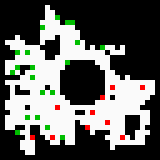

In [91]:
day15_part1(puzzle.input, visualize=True)

In [92]:
def day15a_part2(s):  # Brute-force search of increasing attack power.
  for elf_attack_power in itertools.count(3):
    if result := day15_part1(s, elf_attack_power=elf_attack_power, fail_if_elf_dies=True):
      if 0:
        print(f'Found solution at {elf_attack_power=}')
      return result


check_eq(day15a_part2(s1), 4988)
check_eq(day15a_part2(s11), 31284)
check_eq(day15a_part2(s12), 3478)
check_eq(day15a_part2(s13), 6474)
check_eq(day15a_part2(s14), 1140)

# puzzle.verify(2, day15a_part2)  # Slow.

In [93]:
def day15_part2(s, *, visualize=False):  # Faster bisection search.
  current = 10
  low = high = None
  results = {}
  while True:
    results[current] = result = day15_part1(s, elf_attack_power=current, fail_if_elf_dies=True)
    if result:  # We should try to decrease current.
      high = current
      if low is None:
        current = current // 2
      elif low < current - 1:
        current = (low + high) // 2
      else:
        break
    else:  # We need to increase current.
      low = current
      if high is None:
        current = current * 2
      elif current < high - 1:
        current = (low + high) // 2
      else:
        current = current + 1
        break
  if 0:
    print(f'Found solution at elf_attack_power={current}')
  if visualize:
    day15_part1(s, elf_attack_power=current, fail_if_elf_dies=True, visualize=True)
  return results[current]


check_eq(day15_part2(s1), 4988)
check_eq(day15_part2(s11), 31284)
check_eq(day15_part2(s12), 3478)
check_eq(day15_part2(s13), 6474)
check_eq(day15_part2(s14), 1140)

puzzle.verify(2, day15_part2)  # (elf_attack_power = 19; num_rounds = 40)

(Part 2: 0.203 s)


day15b

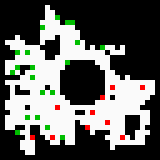

In [94]:
_ = day15_part2(puzzle.input, visualize=True)

<a name="day16"></a>
## Day 16: Inferring opcodes

- Part 1: How many samples in your puzzle input behave like three or more opcodes?

- Part 2: What value is contained in register 0 after executing the test program?

In [95]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2018/day/16), `puzzle.input` has 4_190 lines:

Before: [1, 0, 2, 1]
2 3 2 0
After:  [1, 0, 2, 1]

Before: [1, 0, 2, 2]
11 3 2 1
After:  [1, 0, 2, 2]

 ...
5 2 3 2
5 2 1 2
13 3 2 3
2 3 3 0


The stored answers are: `{1: '677', 2: '540'}`

In [96]:
s1 = """\
Before: [3, 2, 1, 1]
9 2 1 2
After:  [3, 2, 2, 1]
"""

In [97]:
def day16(s, *, part2=False):
  s1, s2 = s.split('\n\n\n\n')
  machine = _Machine(num_registers=4)
  num_operations = len(machine.operations)
  candidates = {op: set(range(num_operations)) for op in machine.operations}
  num_compatible_with_3_or_more = 0
  examples = s1.split('\n\n')
  for example in examples:
    lines = example.splitlines()
    check_eq(len(lines), 3)
    before = list(map(int, lines[0][9:-1].split(',')))
    codes = list(map(int, lines[1].split()))
    after = list(map(int, lines[2][9:-1].split(',')))
    check_eq(len(codes), 4)
    opcode, *operands = codes
    assert 0 <= opcode < num_operations
    num_compatible = 0
    for operation, function in machine.operations.items():
      registers = before.copy()
      function(registers, operands)
      if registers == after:
        num_compatible += 1
      else:
        candidates[operation] -= {opcode}
    num_compatible_with_3_or_more += num_compatible >= 3

  if not part2:
    return num_compatible_with_3_or_more

  operation_from_opcode = {}
  while candidates:
    operation = next(op for op, set_ in candidates.items() if len(set_) == 1)
    (opcode,) = candidates.pop(operation)
    operation_from_opcode[opcode] = operation
    for set_ in candidates.values():
      set_ -= {opcode}
  if 0:
    print(operation_from_opcode)

  machine = _Machine(num_registers=4)
  for line in s2.splitlines():
    codes = list(map(int, line.split()))
    check_eq(len(codes), 4)
    opcode, *operands = codes
    operation = operation_from_opcode[opcode]
    machine.operations[operation](machine.registers, operands)

  return machine.registers[0]


check_eq(day16(s1 + '\n\n\n'), 1)
puzzle.verify(1, day16)

day16_part2 = functools.partial(day16, part2=True)
puzzle.verify(2, day16_part2)

(Part 1: 0.006 s)
(Part 2: 0.008 s)


<a name="day17"></a>
## Day 17: Water falling over reservoirs

- Part 1: How many tiles can the water reach within the range of y values in your scan?

- Part 2: How many water tiles are left after the water spring stops producing water and all remaining water not at rest has drained?

In [98]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2018/day/17), `puzzle.input` has 2_130 lines:

x=360, y=75..98
x=579, y=819..844
y=1262, x=362..366
x=573, y=1593..1621
y=1546, x=508..510
x=284, y=1687..1696
y=1793, x=383..386
x=506, y=254..256
 ...
x=443, y=587..600
x=509, y=504..507
x=300, y=1481..1490
x=628, y=1443..1445


The stored answers are: `{1: '35707', 2: '29293'}`

In [99]:
s1 = """\
x=495, y=2..7
y=7, x=495..501
x=501, y=3..7
x=498, y=2..4
x=506, y=1..2
x=498, y=10..13
x=504, y=10..13
y=13, x=498..504
"""

(Part 1: 0.036 s)


day17

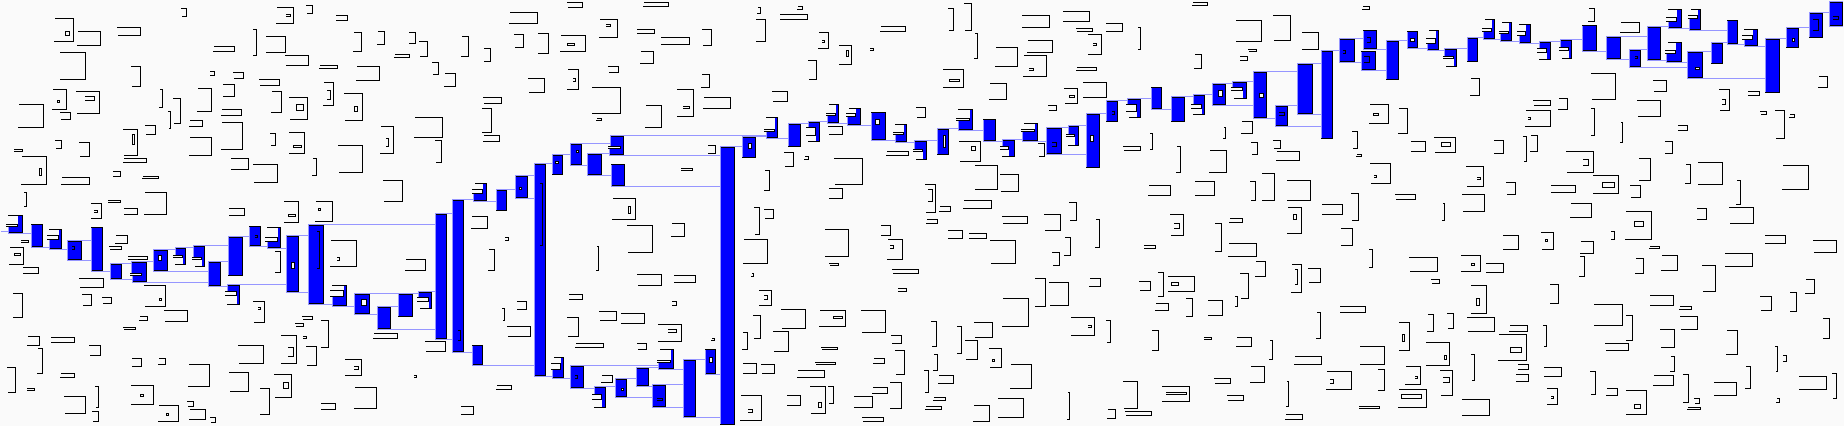

(Part 2: 0.032 s)


In [100]:
def day17(s, *, part2=False, visualize=False):
  grid = {}

  for line in s.splitlines():
    pattern = r'^[xy]=(\d+), [xy]=(\d+)\.\.(\d+)$'
    x, y0, y1 = map(int, hh.re_groups(pattern, line))
    for y in range(y0, y1 + 1):
      yx = (y, x) if line[0] == 'x' else (x, y)
      grid[yx[0], yx[1]] = '#'
  ymin, ymax = min(y for y, x in grid), max(y for y, x in grid)

  def encode(yx):
    return -yx[0], yx[1]

  def decode(yx):
    return -yx[0], yx[1]

  yx = 0, 500
  sources = [encode(yx)]  # heap
  grid[yx] = '|'

  while sources:
    yx = decode(sources[0])
    check_eq(grid[yx], '|')
    if yx[0] == ymax:
      heapq.heappop(sources)
      continue
    y1x = yx[0] + 1, yx[1]
    ch = grid.get(y1x, '.')
    match ch:
      case '|':
        heapq.heappop(sources)
        continue
      case '.':
        grid[y1x] = '|'
        heapq.heappush(sources, encode(y1x))
        continue
      case '~' | '#':
        heapq.heappop(sources)
        bounded = []
        for dx in (-1, 1):
          yx2 = yx
          while True:
            yx2 = yx2[0], yx2[1] + dx
            ch2 = grid.get(yx2, '.')
            assert ch2 != '~'
            if ch2 == '#':
              bounded.append(yx2[1])
              break
            grid[yx2] = '|'
            y1x2 = yx2[0] + 1, yx2[1]
            if ch2 == '.' and y1x2 not in grid:
              heapq.heappush(sources, encode(yx2))
            if grid.get(y1x2, '.') not in '~#':
              break
        if len(bounded) == 2:
          for x in range(bounded[0] + 1, bounded[1]):
            grid[yx[0], x] = '~'
      case _:
        raise ValueError(ch)

  if visualize:
    cmap = {'.': (250,) * 3, '#': (0, 0, 0), '~': (0, 0, 255), '|': (150, 150, 255)}
    image = hh.image_from_yx_map(grid, '.', cmap=cmap, pad=1).transpose(1, 0, 2)
    hh.display_html('Transposed image:')
    media.show_image(image, border=True, title='day17')
    return None

  desired = '~' if part2 else '~|'
  return sum(1 for yx, ch in grid.items() if ymin <= yx[0] <= ymax and ch in desired)


check_eq(day17(s1), 57)
puzzle.verify(1, day17)
day17(puzzle.input, visualize=True)

day17_part2 = functools.partial(day17, part2=True)
check_eq(day17_part2(s1), 29)
puzzle.verify(2, day17_part2)

<a name="day18"></a>
## Day 18: Cellular automaton

- Part 1: What will the total resource value of the lumber collection area be after 10 minutes?

- Part 2: What will the total resource value of the lumber collection area be after 1000000000 minutes?

In [101]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2018/day/18), `puzzle.input` has 50 lines:

|..|#.#|..|#|.##.#..|.#....|.||.#..##...#.#|...|..
|#.||.|...|#.....#|#.#..##|...##....|...#.#|..|.#.
|..|.#.#..|.###..#.|...##|.||...|#...|##..|.....#.
.|..#.#...#|.....#|.#.....#.##.#.....||..|.||#....
#...|..||..|.#|...#.|.#..||....#..#|.....|#.....#.
..|..#.#|.....|.#.|....#...#.#.#|#.#|#....|..#..#.
#....|......||..#.#.#|...#....#.|||.|#....|||.##..
.|.#...|#.#|#|.|....|.||#.|.#||..##.|....#||...|..
 ...
..|#....|..||..|#|.#.#|#.|#..||||.|..|..|.....#.#|
##.......##|...#.|......##..#.|...#.#|#..|...|..#.
|##.#...#.....#.#.|.........#.#|...#...|........||
|.......|........#.##..#.#.#..#..#|.|#|.||#|||...|


The stored answers are: `{1: '574200', 2: '211653'}`

In [102]:
s1 = """\
.#.#...|#.
.....#|##|
.|..|...#.
..|#.....#
#.#|||#|#|
...#.||...
.|....|...
||...#|.#|
|.||||..|.
...#.|..|.
"""

In [103]:
def day18(s, *, num_minutes=10, part2=False, visualize=False):
  grid = hh.grid_from_string(s)

  def evolve_grid():
    grid2 = np.pad(grid, 1, constant_values='.')
    yxs = set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)}
    neighbors = np.array([np.roll(grid2, yx, (0, 1))[1:-1, 1:-1] for yx in yxs])
    num_adjacent_trees = (neighbors == '|').sum(axis=0)
    num_adjacent_lumberyards = (neighbors == '#').sum(axis=0)
    old_grid = grid.copy()
    grid[(old_grid == '.') & (num_adjacent_trees >= 3)] = '|'
    grid[(old_grid == '|') & (num_adjacent_lumberyards >= 3)] = '#'
    grid[(old_grid == '#') & ((num_adjacent_trees < 1) | (num_adjacent_lumberyards < 1))] = '.'

  def resource_value():
    num_trees = np.count_nonzero(grid == '|')
    num_lumberyards = np.count_nonzero(grid == '#')
    return num_trees * num_lumberyards

  if not part2:
    for _ in range(num_minutes):
      evolve_grid()
    return resource_value()

  # Detect a repeating cycle to speed up the evolution.
  images = []
  configs: dict[Any, int] = {}  # hashed_grid -> remaining minute it first appeared.
  remaining_minutes = 1_000_000_000
  period = -1
  for minute in itertools.count():
    if visualize:
      image = hh.to_image(grid == '#', (200, 0, 0), (0, 0, 200))
      image[grid == '|'] = 0, 200, 0
      images.append(image.repeat(3, axis=0).repeat(3, axis=1))
    config = grid.tobytes()  # Hashable; ''.join(grid.flat) is slower.
    if config in configs and period < 0:
      period = configs[config] - remaining_minutes
      remaining_minutes = remaining_minutes % period
      if 0:
        print(f'At minute {minute}, found cycle with period {period}.')
    if not remaining_minutes:
      break
    configs[config] = remaining_minutes
    evolve_grid()
    remaining_minutes -= 1

  if visualize:
    assert period > 0
    hh.display_html('Start of evolution:')
    video = [images[0]] * 20 + images[:50] + [images[49]] * 10
    media.show_video(video, codec='gif', fps=10, title='day18a')
    hh.display_html(f'Cycling {period=}:')
    video = images[-period:]
    media.show_video(video, codec='gif', fps=10, title='day18b')

  return resource_value()


check_eq(day18(s1), 1147)
# day18(puzzle.input, num_minutes=400)
puzzle.verify(1, day18)

day18_part2 = functools.partial(day18, part2=True)
puzzle.verify(2, day18_part2)

(Part 1: 0.005 s)
(Part 2: 0.173 s)


day18a

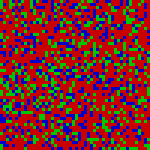

day18b

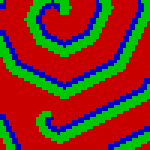

In [104]:
_ = day18_part2(puzzle.input, visualize=True)

<a name="day19"></a>
## Day 19: CPU with instruction pointer

- Part 1: What value is left in register 0 when the background process halts?

- Part 2: What value is left in register 0 when register 0 is started with the value 1?

In [105]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2018/day/19), `puzzle.input` has 37 lines:

#ip 3
addi 3 16 3
seti 1 0 4
seti 1 7 2
mulr 4 2 1
eqrr 1 5 1
addr 1 3 3
addi 3 1 3
 ...
mulr 1 3 1
addr 5 1 5
seti 0 0 0
seti 0 3 3


The stored answers are: `{1: '1430', 2: '14266944'}`

In [106]:
s1 = """\
#ip 0
seti 5 0 1
seti 6 0 2
addi 0 1 0
addr 1 2 3
setr 1 0 0
seti 8 0 4
seti 9 0 5
"""

In [107]:
# Part 1:
# 0 (0, 0, 0, 16, 0, 0)
# 1 (0, 0, 0, 17, 0, 2)
# 2 (0, 0, 0, 18, 0, 4)
# 3 (0, 0, 0, 19, 0, 76)
# 4 (0, 0, 0, 20, 0, 836)
# 5 (0, 6, 0, 21, 0, 836)
# 6 (0, 132, 0, 22, 0, 836)
# 7 (0, 145, 0, 23, 0, 836)
# 8 (0, 145, 0, 24, 0, 981)
# 9 (0, 145, 0, 25, 0, 981)
# 10 (0, 145, 0, 0, 0, 981)  # func_ip1(a=0, f=981)
# ...
# 11 (0, 145, 0, 1, 1, 981)
# 12 (0, 145, 1, 2, 1, 981)
# 13 (0, 1, 1, 3, 1, 981)
# 14 (0, 0, 1, 4, 1, 981)
# 15 (0, 0, 1, 5, 1, 981)
# 16 (0, 0, 1, 7, 1, 981)
# 17 (0, 0, 2, 8, 1, 981)
# 18 (0, 0, 2, 9, 1, 981)
# 19 (0, 0, 2, 10, 1, 981)
# 20 (0, 0, 2, 2, 1, 981)
# ...
# 7702823 (1430, 1, 982, 256, 982, 981)

# Part 2:
# 18 (0, 10550400, 0, 0, 0, 10551381)  # func_ip1(a=0, f=10551381)

# Registers abcdef  (d=IP)
#  1 seti 1 0 4  e = 1
#  2 seti 1 7 2  c = 2
#  3 mulr 4 2 1  # b = e * c
#  4 eqrr 1 5 1
#  5 addr 1 3 3  if e * c == f goto 7
#  6 addi 3 1 3  goto 8
#  7 addr 4 0 0  a += e
#  8 addi 2 1 2  c += 1
#  9 gtrr 2 5 1
# 10 addr 3 1 3  if c > f goto 12
# 11 seti 2 6 3  goto 3
# 12 addi 4 1 4  e += 1
# 13 gtrr 4 5 1
# 14 addr 1 3 3  if e > f goto 16
# 15 seti 1 3 3  goto 2

# def func_ip1(a, f):
#   for e in range(1, f + 1):
#     for c in range(2, f + 1):
#       if e * c == f:
#         a += e

# def func_equivalent(a, f):
#   a += sum(e for e in range(1, f + 1) if f % e == 0)

# def func_equivalent2(a, f):
#   a += sum(factors(f))

In [108]:
def day19(s, *, part2=False, verbose=False):
  def factors(n):
    result = set()
    for i in range(1, int(n**0.5) + 1):
      div, mod = divmod(n, i)
      if mod == 0:
        result |= {i, div}
    return result

  machine = _Machine()
  machine.read_instructions(s)
  optimize = len(machine.instructions) > 10
  if optimize:
    check_eq(machine.instructions[4].operation, 'eqrr')
    register_f = machine.instructions[4].operands[1]
    check_eq(machine.instructions[7].operation, 'addr')
    register_a = machine.instructions[7].operands[2]
  if part2:
    machine.registers[0] = 1
  history = []
  while 0 <= machine.ip < len(machine.instructions):
    if optimize and machine.ip == 1:
      # Unoptimized, part1 is slow, and part2 is way too slow.
      f = machine.registers[register_f]
      machine.registers[register_a] += sum(factors(f))
      machine.ip = 16
    else:
      machine.run_instruction()
    history.append(tuple(machine.registers))
    if len(history) > 10_000_000:
      break

  if verbose:
    for i in range(min(200, len(history))):
      print(i, history[i])
    if len(history) > 200:
      for i in range(0, len(history), 100_000):
        print(i, history[i])
      for i in range(len(history) - 200, len(history)):
        print(i, history[i])

  return machine.registers[0]


check_eq(day19(s1), 6)
puzzle.verify(1, day19)

day19_part2 = functools.partial(day19, part2=True)
puzzle.verify(2, day19_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day20"></a>
## Day 20: Regexp of doors in 2D map

- Part 1: What is the largest number of doors you would be required to pass through to reach a room?

- Part 2: How many rooms have a shortest path from your current location that pass through at least 1000 doors?

In [109]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2018/day/20), `puzzle.input` has a single line of 14_307 characters:

^SWWSWWWNNWSWSESWWWNWNNNNWWWSSSEE(NNWSNESS|)SSWNWSWWNENWNNE(NWWWSWWSEEE(N|SSWWN( ... ))|S)))|SES(WW|S)))|S)))|E)))))|S)$


The stored answers are: `{1: '3415', 2: '8583'}`

In [110]:
# I created a general solution, which can work on inputs that define passageways with 2D cycles.
# However, it appears that all instances of the puzzle inputs give rise to a simple tree
# of passageways?  In the case of a tree, can one simply look for the longest expansion of the
# regular expression?  No, it appears that the regexp expansions may involve backtracking along
# edges of the tree.  My solution is likely overkill for this simpler case.
def day20(s, *, part2=False, visualize=False):
  (s,) = hh.re_groups(r'^\^([SNEW(|)]+)\$$', s.strip())

  def parse(s):
    l = []
    while s and s[0] not in '|)':
      i = next((i for i, ch in enumerate(s) if ch in '(|)'), len(s))
      if i:
        l.append(s[:i])
        s = s[i:]
      else:
        check_eq(s[0], '(')
        l2 = []
        while s[0] != ')':
          l3, s = parse(s[1:])
          l2.append(l3)
          assert s[0] in '|)', s[0]
        l.append(l2)
        s = s[1:]
    return l, s

  l, _ = parse(s)

  def traverse(l):  # Returns three sets: doors_s, doors_e, yxs.
    if not l:
      return set(), set(), set()
    if half := len(l) // 2:
      doors_s1, doors_e1, yxs1 = traverse(l[:half])
      doors_s2, doors_e2, yxs2 = traverse(l[half:])
      return (
          doors_s1 | {(y + v, x + u) for y, x in yxs1 for v, u in doors_s2},
          doors_e1 | {(y + v, x + u) for y, x in yxs1 for v, u in doors_e2},
          {(y + v, x + u) for y, x in yxs1 for v, u in yxs2},
      )
    (elem,) = l
    if isinstance(elem, str):
      doors_s, doors_e = set(), set()
      y, x = 0, 0
      for ch in elem:
        match ch:
          case 'S':
            doors_s.add((y, x))
            y += 1
          case 'N':
            y -= 1
            doors_s.add((y, x))
          case 'E':
            doors_e.add((y, x))
            x += 1
          case 'W':
            x -= 1
            doors_e.add((y, x))
          case '_':
            raise ValueError(ch)
      return doors_s, doors_e, {(y, x)}
    # isinstance(elem, list)
    # Return the three unions of the respective sets from all child nodes.
    return (set().union(*tup) for tup in zip(*map(traverse, elem)))

  doors_s, doors_e, _ = traverse(l)

  if 0 and visualize:

    def symbols_from_doors():
      map1 = {(y * 2 + 1, x * 2): '-' for y, x in doors_s}
      map2 = {(y * 2, x * 2 + 1): '|' for y, x in doors_e}
      return map1 | map2 | {(0, 0): 'X'}

    print(hh.string_from_grid(hh.grid_from_indices(symbols_from_doors(), background='.')))

  yx = 0, 0
  distances = {yx: 0}
  queue = collections.deque([yx])
  while queue:
    yx = queue.popleft()
    for yx2, present in [
        ((yx[0] + 1, yx[1]), yx in doors_s),
        ((yx[0] - 1, yx[1]), (yx[0] - 1, yx[1]) in doors_s),
        ((yx[0], yx[1] + 1), yx in doors_e),
        ((yx[0], yx[1] - 1), (yx[0], yx[1] - 1) in doors_e),
    ]:
      if present and yx2 not in distances:
        distances[yx2] = distances[yx] + 1
        queue.append(yx2)

  if visualize:
    map1 = {}
    for y, x in doors_s:
      map1[y * 2, x * 2] = map1[y * 2 + 1, x * 2] = map1[y * 2 + 2, x * 2] = 1
    for y, x in doors_e:
      map1[y * 2, x * 2] = map1[y * 2, x * 2 + 1] = map1[y * 2, x * 2 + 2] = 1
    map1[0, 0] = 2
    if part2:
      for (y, x), distance in distances.items():
        if distance >= 1000:
          map1[y * 2, x * 2] = 3
    cmap = {0: (0,) * 3, 1: (250,) * 3, 2: (255, 0, 0), 3: (160, 140, 255)}
    image = hh.image_from_yx_map(map1, 0, cmap=cmap, pad=2)
    image = image.repeat(2, axis=0).repeat(2, axis=1)
    media.show_image(image, border=True, title='day20')

  if not part2:
    return max(distances.values())

  return sum(1 for distance in distances.values() if distance >= 1000)


check_eq(day20('^WNE$'), 3)
check_eq(day20('^ENWWW(NEEE|SSE(EE|N))$'), 10)
check_eq(day20('^ENNWSWW(NEWS|)SSSEEN(WNSE|)EE(SWEN|)NNN$'), 18)
check_eq(day20('^ESSWWN(E|NNENN(EESS(WNSE|)SSS|WWWSSSSE(SW|NNNE)))$'), 23)
check_eq(day20('^WSSEESWWWNW(S|NENNEEEENN(ESSSSW(NWSW|SSEN)|WSWWN(E|WWS(E|SS))))$'), 31)
puzzle.verify(1, day20)

(Part 1: 0.300 s)


In [111]:
day20_part2 = functools.partial(day20, part2=True, visualize=False)
puzzle.verify(2, day20_part2)

(Part 2: 0.303 s)


day20

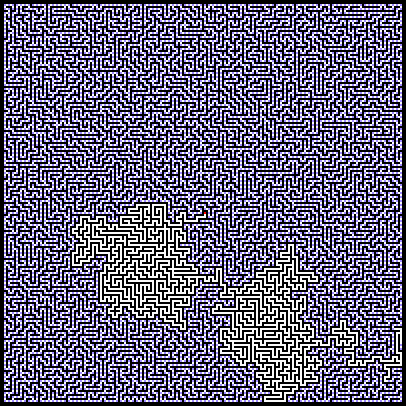

In [112]:
_ = day20_part2(puzzle.input, visualize=True)

In [113]:
if 0:  # Due to backtracking, one cannot simply look for longest expansion.

  def day20a(s):
    (s,) = hh.re_groups(r'^\^([SNEW(|)]+)\$$', s.strip())

    def max_regex_length(s):
      max_len = 0
      while s and s[0] not in '|)':
        i = next((i for i, ch in enumerate(s) if ch in '(|)'), len(s))
        if i:
          max_len += i
          s = s[i:]
        else:
          check_eq(s[0], '(')
          max_lens = []
          while s[0] != ')':
            len_child, s = max_regex_length(s[1:])
            max_lens.append(len_child)
            assert s[0] in '|)', s[0]
          max_len += max(max_lens)
          s = s[1:]
      return max_len, s

    max_len, _ = max_regex_length(s)
    return max_len

  check_eq(day20a('^WNE$'), 3)
  check_eq(day20a('^ENWWW(NEEE|SSE(EE|N))$'), 10)
  check_eq(day20a('^ENNWSWW(NEWS|)SSSEEN(WNSE|)EE(SWEN|)NNN$'), 18)

<a name="day21"></a>
## Day 21: Smallest value causing halt

- Part 1: What is the lowest non-negative integer value for register 0 that causes the program to halt after executing the fewest instructions?

- Part 2: What is the lowest non-negative integer value for register 0 that causes the program to halt after executing the most instructions?

In [114]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2018/day/21), `puzzle.input` has 32 lines:

#ip 1
seti 123 0 4
bani 4 456 4
eqri 4 72 4
addr 4 1 1
seti 0 0 1
seti 0 8 4
bori 4 65536 3
 ...
seti 7 5 1
eqrr 4 0 5
addr 5 1 1
seti 5 3 1


The stored answers are: `{1: '15823996', 2: '10199686'}`

In [115]:

if 0:
  print('\n'.join(f'# {i:2} {line:18} # ' for i, line in enumerate(puzzle.input.splitlines()[1:])))

#  0 seti 123 0 4       # e = 123
#  1 bani 4 456 4       # e &= 456
#  2 eqri 4 72 4
#  3 addr 4 1 1         # if e == 72: goto 5
#  4 seti 0 0 1         # goto 1
#  5 seti 0 8 4         # e = 0
# BEGIN
#  6 bori 4 65536 3     # d = e | 65536
#  7 seti 16098955 8 4  # e = 16098955
#  8 bani 3 255 5       # f = d & 255
#  9 addr 4 5 4         # e += f
# 10 bani 4 16777215 4  # e &= 16777215
# 11 muli 4 65899 4     # e *= 65899
# 12 bani 4 16777215 4  # e &= 16777215
# 13 gtir 256 3 5
# 14 addr 5 1 1         # if d < 256: goto 16
# 15 addi 1 1 1         # goto 17
# 16 seti 27 3 1        # goto 28
# 17 seti 0 7 5         # f = 0
# 18 addi 5 1 2         # c = f + 1
# 19 muli 2 256 2       # c *= 256
# 20 gtrr 2 3 2
# 21 addr 2 1 1         # if c > d: goto 23
# 22 addi 1 1 1         # goto 24
# 23 seti 25 1 1        # goto 26
# 24 addi 5 1 5         # f += 1
# 25 seti 17 6 1        # goto 18
# 26 setr 5 4 3         # d = f
# 27 seti 7 5 1         # goto 8
# 28 eqrr 4 0 5
# 29 addr 5 1 1         # if e == a: goto 31 (halt)
# 30 seti 5 3 1         # goto 6

# def func(a):
#   d = 65536
#   e = 16098955
#   while True:
#     f = d & 255
#     e += f
#     e &= 16777215  # 0xFFFFFF (24-bit)
#     e *= 65899
#     e &= 16777215
#     if d < 256:
#       if e == a:
#         break  # halt!
#       d = e | 65536
#       e = 16098955
#       continue
#     f = 0
#     while True:
#       c = f + 1
#       c *= 256
#       if c > d:
#         d = f
#         break
#       f += 1

# def func(a):
#   d = 65536
#   e = 16098955
#   while True:
#     f = d & 255
#     e += f
#     e &= 16777215  # 0xFFFFFF (24-bit)
#     e *= 65899
#     e &= 16777215
#     if d < 256:
#       if e == a:
#         break  # halt!
#       d = e | 65536
#       e = 16098955
#       continue
#     d //= 256

In [116]:
def day21_test():
  def simulate(max_count=10_000_000, verbose=False):
    d = 65536
    e = 16098955
    for _ in range(max_count):
      e += d & 255
      e &= 16777215  # 0xFFFFFF (24-bit)
      e *= 65899
      e &= 16777215
      if verbose:
        hh.show(a, d, e)
      if d < 256:
        yield e
        d = e | 65536
        e = 16098955
        continue
      d //= 256

  def count_for(a, max_count=10_000_000, verbose=False):
    for count, e in enumerate(simulate(verbose=verbose)):
      if count >= max_count:
        return None
      if e == a:
        return count + 1
    return None

  def sweep(max_a, max_count):
    for a in range(max_a):
      if count := count_for(a, max_count=max_count):
        hh.show(a, count)

  if 0:
    sweep(max_a=1_000_000, max_count=1_000)
    sweep(max_a=16_777_216, max_count=10)
    # a = 2014420, count = 5
    # a = 12063646, count = 8
    # a = 15823996, count = 2

  for a in [15823996]:
    count = count_for(a, verbose=True)
    hh.show(count)
  # a = 15823996, d = 65536, e = 14559001
  # a = 15823996, d = 256, e = 1732723
  # a = 15823996, d = 1, e = 15823996
  # count = 2
  # This makes sense --- it is the simplest solution -- I should have inferred
  # this earlier.

  def find_last_unique_element():
    results = {}
    for e in simulate(max_count=20_000_000):
      results[e] = 1
    print(len(results), list(results)[-5:])

  find_last_unique_element()
  # 11457 [9486379, 5590365, 182116, 12821901, 10199686]


# day21_test()

In [117]:
def day21(s, *, part2=False):
  machine = _Machine()
  machine.read_instructions(s)

  def gen_sequence():
    machine.registers = [0, 0, 0, 0, 0, 0]
    check_eq(machine.instructions[28].operation, 'eqrr')
    register_e = machine.instructions[28].operands[0]
    check_eq(machine.instructions[17].operation, 'seti')
    check_eq(machine.instructions[17].operands[0], 0)
    check_eq(machine.instructions[26].operation, 'setr')
    register_d = machine.instructions[26].operands[2]
    while True:
      assert 0 <= machine.ip < len(machine.instructions)
      if machine.ip == 28:  # Intercept generated number and disable halting.
        # 28 eqrr 4 0 5
        # 29 addr 5 1 1         # if e == a: goto 31 (halt)
        yield machine.registers[register_e]
        machine.ip = 30
        continue
      if machine.ip == 17:  # Speed up the "d //= 256" computation.
        # 17 seti 0 7 5         # f = 0
        # ...
        # 26 setr 5 4 3         # d = f
        machine.registers[register_d] //= 256
        machine.ip = 27
        continue
      machine.run_instruction()

  if not part2:
    return next(gen_sequence())

  results: dict[int, int] = {}
  for a in gen_sequence():
    if a in results:
      if 0:
        print(f'Found {len(results)} numbers before first repetition.')
      return list(results)[-1]  # Last number before first repetition.
    results[a] = 1


puzzle.verify(1, day21)

day21_part2 = functools.partial(day21, part2=True)
puzzle.verify(2, day21_part2)

(Part 1: 0.000 s)
(Part 2: 0.194 s)


<a name="day22"></a>
## Day 22: Shortest path with tools

- Part 1: What is the total risk level for the smallest rectangle that includes 0,0 and the target's coordinates?

- Part 2: What is the fewest number of minutes you can take to reach the target?

In [118]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2018/day/22), `puzzle.input` has 2 lines:

depth: 8103
target: 9,758


The stored answers are: `{1: '7743', 2: '1029'}`

In [119]:
s1 = """\
depth: 510
target: 10,10
"""

The approach is to find shortest path over a 3D grid (y, x, item (0..2)), with some padding beyond the target location because the path may lie outside the the tight bounding box.

I first try the useful graph library `networkx`, comparing the simple Dijkstra algorithm and the `A*` algorithm.  The `A*` algorithm is actually slower, which makes sense because the search domain is a rather tight box bounding the source and target locations.

I obtain faster results using a manual implementation of the Dijkstra algorithm.  This is expected because the `networkx` data structure has overhead due to its many nested `dict` elements.

In [120]:
# https://www.reddit.com/r/adventofcode/comments/a8i1cy/comment/ecazvbe
def day22a(s, *, part2=False, pad=60):  # Using networkx; slower.
  rocky, wet, narrow = 0, 1, 2
  del narrow  # unused
  torch, gear, neither = 0, 1, 2
  valid_items = {rocky: (torch, gear), wet: (gear, neither), neither: (torch, neither)}

  def get_cave():
    lines = iter(line for line in s.splitlines())
    depth = int(next(lines)[len('depth: ') :])
    target = tuple(int(n) for n in next(lines)[len('target: ') :].split(','))
    return depth, target

  def generate_grid(depth, shape):
    # (x, y) -> geologic index, erosion level, risk
    grid: dict[tuple[int, int], tuple[int, int, int]] = {}
    for y, x in np.ndindex((shape[1], shape[0])):
      if (x, y) in [(0, 0), target]:
        geo = 0
      elif x == 0:
        geo = y * 48271
      elif y == 0:
        geo = x * 16807
      else:
        geo = grid[x - 1, y][1] * grid[x, y - 1][1]
      ero = (geo + depth) % 20183
      risk = ero % 3
      grid[x, y] = geo, ero, risk
    return grid

  def generate_graph(grid, shape):
    # Note: Using add_weighted_edges_from() just ends up calling add_edge().
    # Note: Using np.array for grid is actually slower.
    graph = nx.Graph()
    for y, x in np.ndindex((shape[1], shape[0])):
      item0, item1 = valid_items[grid[x, y]]
      graph.add_edge((x, y, item0), (x, y, item1), weight=7)
    for y, x in np.ndindex((shape[1] - 1, shape[0] - 1)):
      items = set(valid_items[grid[x, y]])
      for dx, dy in ((0, 1), (1, 0)):
        new_x, new_y = x + dx, y + dy
        new_items = valid_items[grid[new_x, new_y]]
        for item in items.intersection(new_items):
          graph.add_edge((x, y, item), (new_x, new_y, item), weight=1)
    return graph

  def cost_lower_bound(xyi1, xyi2):
    (x1, y1, item1), (x2, y2, item2) = xyi1, xyi2
    return abs(x1 - x2) + abs(y1 - y2) + (7 if item1 != item2 else 0)

  depth, target = get_cave()
  if not part2:
    shape = target[0] + 1, target[1] + 1
    grid = generate_grid(depth, shape)
    return sum(v[2] for v in grid.values())

  import networkx as nx

  shape = target[0] + pad, target[1] + pad
  grid = {c: v[2] for c, v in (generate_grid(depth, shape)).items()}
  graph = generate_graph(grid, shape)
  use_astar = True
  if use_astar:
    return nx.astar_path_length(graph, (0, 0, torch), (*target, torch), heuristic=cost_lower_bound)
  return nx.dijkstra_path_length(graph, (0, 0, torch), (*target, torch))


check_eq(day22a(s1), 114)
puzzle.verify(1, day22a)

if not importlib.util.find_spec('networkx'):
  print('Module networkx is unavailable.')
else:
  day22a_part2 = functools.partial(day22a, part2=True)
  check_eq(day22a_part2(s1), 45)
  # puzzle.verify(2, day22a_part2)  # Slow using Dijkstra; even slower (~1.5 x) using A*.

(Part 1: 0.008 s)


In [121]:
# With numba.
@numba.njit
def day22_dijkstra(grid, target_yx, visualize):
  # https://levelup.gitconnected.com/dijkstra-algorithm-in-python-8f0e75e3f16e
  TORCH = 1
  distances = {}
  # pylint: disable-next=consider-using-set-comprehension
  visited = set([(0, 0, 0) for _ in range(0)])  # Typed empty set.
  parents = {(0, 0, 0): (0, 0, 0)}  # Dummy entry for numba typing.
  source_tyx = TORCH, 0, 0
  target_tyx = TORCH, *target_yx
  distances[source_tyx] = 0
  pq = [(0, source_tyx)]
  tool_change = np.array([[-1, 2, 1], [2, -1, 0], [1, 0, -1]])

  while pq:
    distance, node = heapq.heappop(pq)
    if node in visited:
      continue
    visited.add(node)
    if node == target_tyx:
      break

    def consider(node2, edge_cost):
      if ~(node2 in visited):  # (Workaround for numba bug "not in".)
        distance2 = distance + edge_cost
        if distance2 < distances.get(node2, 10**8):
          distances[node2] = distance2
          heapq.heappush(pq, (distance2, node2))
          if visualize:
            parents[node2] = node

    tool, y, x = node
    if y > 0 and grid[y - 1, x] != tool:
      consider((tool, y - 1, x), 1)
    if x > 0 and grid[y, x - 1] != tool:
      consider((tool, y, x - 1), 1)
    if y < grid.shape[0] - 1 and grid[y + 1, x] != tool:
      consider((tool, y + 1, x), 1)
    if x < grid.shape[1] - 1 and grid[y, x + 1] != tool:
      consider((tool, y, x + 1), 1)
    consider((tool_change[tool, grid[y, x]], y, x), 7)
  else:
    raise RuntimeError

  path = [node]
  while node in parents:
    node = parents[node]
    path.append(node)
  return distance, path[::-1] if visualize else None


def day22(s, *, part2=False, pad=60, visualize=False):
  lines = s.splitlines()
  depth = int(hh.re_groups(r'^depth: (\d+)$', lines[0])[0])
  target_yx = tuple(map(int, hh.re_groups(r'^target: (\d+),(\d+)$', lines[1])))[::-1]

  def construct_grid(shape):
    erosion_level = np.empty(shape, np.int64)
    for y, x in np.ndindex(shape):
      if y == 0:
        geologic_index = x * 16807
      elif x == 0:
        geologic_index = y * 48271
      elif (y, x) == target_yx:
        geologic_index = 0
      else:
        geologic_index = erosion_level[y - 1, x] * erosion_level[y, x - 1]
      erosion_level[y, x] = (geologic_index + depth) % 20183
    return erosion_level % 3

  if not part2:
    shape = tuple(np.array(target_yx) + 1)
    return construct_grid(shape).sum()

  shape = tuple(np.array(target_yx) + pad)
  grid = construct_grid(shape)
  distance, path = day22_dijkstra(grid, target_yx, visualize)
  if visualize:
    image = hh.to_image(grid == 1, (150, 0, 0), (0, 150, 0))
    image[grid == 2] = 0, 0, 150
    image2 = image.copy()
    for node in path:
      image2[node[1:]] += 105  # Let the path be brighter.
    # x_max = (image.sum(2) > 0).max(axis=0).argmin() + 5
    image = image.transpose(1, 0, 2).repeat(2, axis=0).repeat(2, axis=1)
    image2 = image2.transpose(1, 0, 2).repeat(2, axis=0).repeat(2, axis=1)
    media.show_video([image, image2], codec='gif', fps=1, title='day22')
  return distance


check_eq(day22(s1), 114)
puzzle.verify(1, day22)

day22_part2 = functools.partial(day22, part2=True)
check_eq(day22_part2(s1), 45)  # Slow for numba compilation.
puzzle.verify(2, day22_part2)

(Part 1: 0.005 s)
(Part 2: 0.092 s)


day22

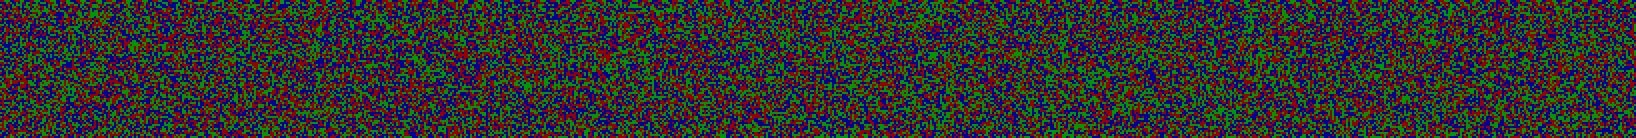

In [122]:
_ = day22_part2(puzzle.input, visualize=True)

<a name="day23"></a>
## Day 23: Position in most octahedra

- Part 1: Find the nanobot with the largest signal radius. How many nanobots are in range of its signals?

- Part 2: Find the coordinates that are in range of the largest number of nanobots. What is the shortest manhattan distance between any of those points and `0,0,0`?

In [123]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2018/day/23), `puzzle.input` has 1_000 lines:

pos=<17821750,69850551,48570194>, r=59707711
pos=<-9331508,90659413,35938523>, r=95038229
pos=<23833901,-25701718,28216348>, r=82407742
pos=<22578717,-4001237,33580852>, r=67327107
pos=<-15164551,39459126,39763570>, r=67792575
pos=<15583848,-13445920,16647903>, r=75695712
pos=<17429546,42820351,39605202>, r=55571372
pos=<25306171,10112187,37105526>, r=54010804
 ...
pos=<47372138,56694644,64140898>, r=73726557
pos=<-37628346,45604673,30927256>, r=75274807
pos=<9855134,42554936,63900237>, r=63813785
pos=<75613424,50145291,41345801>, r=72623408


The stored answers are: `{1: '599', 2: '94481130'}`

In [124]:
s1 = """\
pos=<0,0,0>, r=4
pos=<1,0,0>, r=1
pos=<4,0,0>, r=3
pos=<0,2,0>, r=1
pos=<0,5,0>, r=3
pos=<0,0,3>, r=1
pos=<1,1,1>, r=1
pos=<1,1,2>, r=1
pos=<1,3,1>, r=1
"""

In [125]:
s2 = """\
pos=<10,12,12>, r=2
pos=<12,14,12>, r=2
pos=<16,12,12>, r=4
pos=<14,14,14>, r=6
pos=<50,50,50>, r=200
pos=<10,10,10>, r=5
"""

In [126]:
def day23a(s, *, part2=False):
  positions0, radii0 = [], []
  for line in s.splitlines():
    pattern = r'^pos=<([0-9-]+),([0-9-]+),([0-9-]+)>, r=(\d+)$'
    x, y, z, r = map(int, hh.re_groups(pattern, line))
    positions0.append((x, y, z))
    radii0.append(r)
  positions, radii = np.array(positions0), np.array(radii0)

  # With Manhattan distance, the in-range region in dimension D is a cocube
  # (e.g., an octahedron for D=3).  To efficiently represent intersections of
  # cocubes, we use a polytope (bounded convex polyhedron), defined as the
  # intersection of half-spaces (each hyperplane parallel to a cocube face).
  # The extent of the polytope is represented by an 2**D-dimensional vector `d`.
  # Each tuple coefficient d_i represents a hyperplane of a cocube face.
  # For D=3, each of the 8 half-spaces is a linear inequality on (x, y, z):
  #  h[0] * x + h[1] * y + h[2] * z <= d_i,
  # where face 0 has h = (-1, -1, -1),  face 1 has h = (-1, -1, 1), etc.

  hvalues = tuple(itertools.product((-1, 1), repeat=3))  # shape [8, 3]
  polytopes = [
      tuple(np.dot(h, position) + radius for h in hvalues)
      for position, radius in zip(positions, radii)
  ]

  def num_in_range(position):
    return np.count_nonzero(abs(positions - position).sum(axis=1) <= radii)

  def point_in_polytope(position, polytope):
    return all(np.dot(h, position) <= d for h, d in zip(hvalues, polytope))

  def intersect(polytope1, polytope2):
    return tuple(np.minimum(polytope1, polytope2))

  def is_empty(polytope):
    # Note that half-space h[i] is in opposite direction of h[-(i + 1)].
    p = polytope
    return p[0] < -p[7] or p[1] < -p[6] or p[2] < -p[5] or p[3] < -p[4]

  def is_infinite(polytope):
    return min(polytope) == math.inf

  if not part2:
    if 1:  # Faster.
      i0 = radii.argmax()
      return np.count_nonzero(abs(positions - positions[i0]).sum(axis=1) <= radii[i0])
    # Sanity check on polytopes.
    polytope = polytopes[radii.argmax()]
    return sum(1 for p in positions if point_in_polytope(p, polytope))

  # Estimate an initial position with a high count of overlapping octahedra.
  good_position = tuple(max(positions, key=num_in_range))

  # len(polytopes2) = 529, max_count = 528; 0.4 s.
  distance_threshold, prune_allowance = 10_000_000, 8

  while True:
    good_ds = tuple(np.dot(hvalue, good_position) for hvalue in hvalues)
    # hh.show(good_position, num_in_range(good_position))
    # good_position = (22000266, 38655032, 24842411), num_in_range(good_position) = 831

    # Modify a polytope to ignore any half-space whose linear boundary is
    # distant from good_position.
    def omit_far_halfspaces(polytope, good_ds):
      return tuple(
          d if abs(d - good_d) < distance_threshold else math.inf
          for d, good_d in zip(polytope, good_ds)
      )

    polytopes2 = [omit_far_halfspaces(p, good_ds) for p in polytopes]
    polytopes2 = [p for p in polytopes2 if not is_infinite(p)]

    # Heuristically order the polytopes.
    polytopes2 = sorted(polytopes2, key=lambda p: np.abs(p).min())
    polytopes2 = list(reversed(polytopes2))

    pieces: dict[tuple[int, ...], int] = {}  # polytope -> count_of_original_octahedra
    for i, polytope in enumerate(polytopes2):
      new_pieces: dict[tuple[int, ...], int] = {}
      for piece, count in pieces.items():
        piece2 = intersect(polytope, piece)
        if is_empty(piece2):
          continue
        new_pieces[piece2] = max(count + 1, pieces.get(piece2, 0), new_pieces.get(piece2, 0))
      pieces.update(new_pieces)
      pieces[polytope] = max(1, pieces.get(polytope, 0))
      if prune_allowance:
        pieces = {piece: count for piece, count in pieces.items() if count > i - prune_allowance}

    max_count = max(pieces.values())
    max_list = [piece for piece, count in pieces.items() if count == max_count]
    (best_polytope,) = max_list
    if len(polytopes2) - max_count > prune_allowance:
      print('Warning: pruning too large to guarantee the optimal solution.')

    min_distance = math.inf
    # for c in set(itertools.product([-1, 0, 1], repeat=3)) - {0, 0, 0}:
    # for c in hvalues:
    for c in [-np.sign(good_position)]:
      c = np.array(c, np.float64)
      matrix_ub = np.array(hvalues)
      b_ub = np.nan_to_num(best_polytope, posinf=10**10)
      res = scipy.optimize.linprog(c, matrix_ub, b_ub, method='highs')
      check_eq(res.success, True)
      # Handle the case of results with half-integer coordinates.
      upper = tuple(np.floor(np.mod(res.x, 1.0) + 1.499).astype(int))
      for delta in np.ndindex(upper):
        position = tuple((res.x + delta).astype(int))
        in_polytope = point_in_polytope(position, best_polytope)
        distance = np.abs(position).sum()
        if in_polytope:
          min_distance = min(min_distance, distance)
          best_position = position
    distance_from_good = abs(np.array(best_position) - good_position).sum()
    if 0:
      hh.show(best_position, min_distance, distance_from_good, num_in_range(best_position))
      # best_position = (26794906, 46607439, 21078785), min_distance = 94481130, distance_from_good = 16510673, num_in_range(best_position) = 977
    if distance_from_good <= distance_threshold:
      break
    good_position = best_position
    prune_allowance = 4

  return min_distance


check_eq(day23a(s1), 7)
puzzle.verify(1, day23a)

day23a_part2 = functools.partial(day23a, part2=True)
check_eq(day23a_part2(s2), 36)
# puzzle.verify(2, day23a_part2)  # Slow.

(Part 1: 0.012 s)


In [127]:
def day23b(s, *, part2=False):
  # Divide-and-conquer using octree decomposition, inspired by
  # https://github.com/wimglenn/advent-of-code-wim/blob/master/aoc_wim/aoc2018/q23.py.
  pattern = r'^pos=<([0-9-]+),([0-9-]+),([0-9-]+)>, r=(\d+)$'
  data: Any = np.array([list(map(int, hh.re_groups(pattern, line))) for line in s.splitlines()])
  xs, rs = data[:, :3], data[:, 3]
  i = rs.argmax()
  if not part2:
    return (abs(xs - xs[i]).sum(axis=1) <= rs[i]).sum()

  x0 = xs.min(axis=0)
  priority_queue = [(0, xs.ptp(axis=0).max(), abs(x0).sum(), *x0)]
  while priority_queue:
    n_out_of_range, s, d, *x0 = heapq.heappop(priority_queue)
    x = np.array(x0)
    s //= 2
    if not s:
      # return d
      x0 = x
      break
    dx = np.array(list(itertools.product([0, 1], repeat=3))) * s
    for row in x + dx:  # Consider 8 octree child cells.
      # Maximize number in range = minimize number out of range.
      lo = np.maximum(row - xs, 0)
      hi = np.maximum(xs - row - s + 1, 0)  # (xs - row1);  row1 = row + s - 1
      n_out = ((lo + hi).sum(axis=1) > rs).sum()
      if n_out < len(rs):
        heapq.heappush(priority_queue, (n_out, s, abs(row).sum(), *row))
  else:
    raise RuntimeError

  # Search around neighborhood of x0.
  r = 8
  for dx in itertools.product(range(-r, r + 1), repeat=3):
    x = x0 + dx
    n_out = (abs(xs - x).sum(axis=1) > rs).sum()
    n_out_of_range, d = min((n_out_of_range, d), (n_out, abs(x).sum()))

  return d


check_eq(day23b(s1), 7)
puzzle.verify(1, day23b)

day23b_part2 = functools.partial(day23b, part2=True)
check_eq(day23b_part2(s2), 36)
puzzle.verify(2, day23b_part2)

(Part 1: 0.002 s)
(Part 2: 0.197 s)


In [128]:
def day23(s, *, part2=False):
  # Divide-and-conquer using octree decomposition, adapted from
  # https://github.com/wimglenn/advent-of-code-wim/blob/master/aoc_wim/aoc2018/q23.py.
  # Improved to be robust (not assuming cubes with power-of-two dimensions).
  pattern = r'^pos=<([0-9-]+),([0-9-]+),([0-9-]+)>, r=(\d+)$'
  data: Any = np.array([list(map(int, hh.re_groups(pattern, line))) for line in s.splitlines()])
  xs, rs = data[:, :-1], data[:, -1]
  if not part2:
    i = rs.argmax()
    return (abs(xs - xs[i]).sum(axis=1) <= rs[i]).sum()

  xl, xh = xs.min(axis=0), xs.max(axis=0)
  pq = [(0, (xh - xl).max(), abs(xl).sum(), tuple(xl), tuple(xh))]
  while pq:
    n_out, s, d, xl, xh = heapq.heappop(pq)
    if s == 0:
      return d
    xm = (np.array(xl) + xh) // 2  # Partition into up to 8 octree child cells.
    for child_min_max in itertools.product(
        *(((l, m), (m + 1, h)) if m < h else ((l, h),) for l, m, h in zip(xl, xm, xh))
    ):
      xl, xh = np.array(child_min_max).T
      # Maximize num in-range = minimize num out-of-range.
      n_out = ((np.maximum(xl - xs, 0) + np.maximum(xs - xh, 0)).sum(axis=1) > rs).sum()
      heapq.heappush(pq, (n_out, (xh - xl).max(), abs(xl).sum(), tuple(xl), tuple(xh)))


check_eq(day23(s1), 7)
puzzle.verify(1, day23)

day23_part2 = functools.partial(day23, part2=True)
check_eq(day23_part2(s2), 36)
puzzle.verify(2, day23_part2)

(Part 1: 0.002 s)
(Part 2: 0.041 s)


<a name="day24"></a>
## Day 24: Armies with groups of units

- Part 1: How many units would the winning army have?

- Part 2: How many units does the immune system have left after getting the smallest boost it needs to win?

In [129]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2018/day/24), `puzzle.input` has 23 lines:

Immune System:
956 units each with 7120 hit points (weak to bludgeoning, slashing) with an atta ... 71 radiation damage at initiative 7
1155 units each with 5643 hit points (weak to bludgeoning; immune to cold) with  ... 42 slashing damage at initiative 15
1658 units each with 5507 hit points (weak to cold; immune to bludgeoning, slash ... 32 radiation damage at initiative 3
5009 units each with 8078 hit points with an attack that does 14 slashing damage at initiative 8
22 units each with 4771 hit points (weak to radiation) with an attack that does 1906 bludgeoning damage at initiative 18
115 units each with 9090 hit points (immune to slashing; weak to bludgeoning) wi ... 72 slashing damage at initiative 17
1062 units each with 11023 hit points (immune to cold, radiation; weak to bludge ... oes 93 fire damage at initiative 19
 ...
3143 units each with 53472 hit points (immune to cold; weak to fire) with an att ... 30 slashing damage at initiative 16
451 units each with 28782 hit points

The stored answers are: `{1: '15392', 2: '1092'}`

In [130]:
s1 = """\
Immune System:
17 units each with 5390 hit points (weak to radiation, bludgeoning) with an attack that does 4507 fire damage at initiative 2
989 units each with 1274 hit points (immune to fire; weak to bludgeoning, slashing) with an attack that does 25 slashing damage at initiative 3

Infection:
801 units each with 4706 hit points (weak to radiation) with an attack that does 116 bludgeoning damage at initiative 1
4485 units each with 2961 hit points (immune to radiation; weak to fire, cold) with an attack that does 12 slashing damage at initiative 4
"""

In [131]:
def day24(s, *, verbose=False, boost=0, immune_must_win=False):
  @dataclasses.dataclass
  class Group:
    army: Army
    id: int
    units: int
    hit_points: int  # (per_unit)
    attack_damage: int  # (per unit)
    attack_type: str
    initiative: int  # Higher initiative attacks first and wins ties.
    attributes: dict[str, set[str]]  # ['immune'] and ['weak']
    target: Group | None
    targeted: bool

    def __init__(self, army, id, line):
      self.army = army
      self.id = id
      pattern = (
          r'^(\d+) units each with (\d+) hit points( \(.*\))? with'
          r' an attack that does (\d+) (.*) damage at initiative (\d+)$'
      )
      units, hit_points, attributes, attack_damage, attack_type, initiative = hh.re_groups(
          pattern, line
      )
      self.units, self.hit_points, self.attack_damage, self.attack_type, self.initiative = (
          int(units),
          int(hit_points),
          int(attack_damage),
          attack_type,
          int(initiative),
      )
      self.attributes = {'immune': set(), 'weak': set()}
      if attributes:
        for attribute in attributes[2:-1].split('; '):
          t, ss = attribute.split(' to ')
          for s in ss.split(', '):
            self.attributes[t].add(s)
      if boost and army.name == 'Immune System':
        self.attack_damage += boost

    def effective_power(self):
      return self.units * self.attack_damage

    def selection_order(self):
      return -self.effective_power(), -self.initiative

  @dataclasses.dataclass
  class Army:
    name: str
    groups: list[Group]

    def __init__(self, s):
      lines = s.splitlines()
      self.name = lines[0][:-1]
      self.groups = [Group(self, i + 1, line) for i, line in enumerate(lines[1:])]

  armies = [Army(s_army) for s_army in s.split('\n\n')]

  def get_opponent(army):
    return next(army2 for army2 in armies if army2 != army)

  def compute_damage(group, target):
    assert group.army != target.army
    damage = group.effective_power()
    if group.attack_type in target.attributes['immune']:
      damage = 0
    if group.attack_type in target.attributes['weak']:
      damage *= 2
    return damage

  while True:
    if verbose:
      for army in armies:
        print(f'{army.name}:')
        for group in army.groups:
          print(f'Group {group.id} contains {group.units} units')
      print()

    if any(not army.groups for army in armies):
      break

    # Target selection.
    for army in armies:
      for group in army.groups:
        group.targeted = False
    for army in armies:
      opponent = get_opponent(army)

      def key(g):
        return (not g.targeted, compute_damage(group, g), g.effective_power(), g.initiative)

      for group in sorted(army.groups, key=lambda g: g.selection_order()):
        target = max(opponent.groups, key=key)
        damage = compute_damage(group, target)
        if target.targeted or damage == 0:
          group.target = None
        else:
          group.target = target
          target.targeted = True
          if verbose and target:
            print(f'{army.name=} {group.id=} would deal defending group {target.id=} {damage=}')
    if verbose:
      print()

    # Attacking.
    total_killed = 0
    for group in sorted(
        (group for army in armies for group in army.groups), key=lambda g: -g.initiative
    ):
      if group.units == 0 or not group.target or group.target.units == 0:
        continue
      target = group.target
      damage = compute_damage(group, target)
      units_killed = min(damage // target.hit_points, target.units)
      if verbose:
        print(f'{group.army.name=} {group.id=} attacks {target.id=} -> {units_killed=}')
      target.units -= units_killed
      total_killed += units_killed
    if verbose:
      print()
    if total_killed == 0:
      return None  # The fight is a draw.

    # Remove empty groups.
    for army in armies:
      army.groups = [group for group in army.groups if group.units > 0]

  army = next(army for army in armies if army.groups)
  if immune_must_win and army.name != 'Immune System':
    return None
  return sum(group.units for group in army.groups)


check_eq(day24(s1), 5216)
puzzle.verify(1, day24)

(Part 1: 0.031 s)


In [132]:
def day24_part2(s):
  def boost_result(boost):
    return day24(s, boost=boost, immune_must_win=True)

  def binary_search(func, lower, upper):
    """Returns lowest x for which bool(func(x)) is True."""
    if 0:
      check_eq(func(lower), None)
      check_eq(func(upper) is not None, True)
    while lower + 1 < upper:
      mid = (lower + upper) // 2
      if func(mid):
        upper = mid
      else:
        lower = mid
    return upper

  boost = binary_search(boost_result, lower=0, upper=2_000)
  if 0:
    print(f'Found solution with {boost=}')
  return boost_result(boost)


check_eq(day24(s1, boost=1570), 51)
check_eq(day24_part2(s1), 51)

puzzle.verify(2, day24_part2)

(Part 2: 0.428 s)


<a name="day25"></a>
## Day 25: Clustering nearby 4D points

- Part 1: Given a set of 4D points, what is the number of clusters of points when edges connect points with Manhattan distance 3 or less?

- Part 2: No second part on day 25.

In [133]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2018/day/25), `puzzle.input` has 1_441 lines:

4,-5,0,-4
0,3,-3,2
-6,5,-7,4
6,-3,-1,-3
-5,4,0,-6
8,-6,-7,7
0,-7,6,5
-5,-6,4,0
 ...
2,1,-7,-7
-7,-8,5,1
2,-1,-3,1
0,-6,-3,-3


The stored answers are: `{1: '359', 2: ''}`

In [134]:
s1 = """\
 0,0,0,0
 3,0,0,0
 0,3,0,0
 0,0,3,0
 0,0,0,3
 0,0,0,6
 9,0,0,0
12,0,0,0
"""

s2 = """\
-1,2,2,0
0,0,2,-2
0,0,0,-2
-1,2,0,0
-2,-2,-2,2
3,0,2,-1
-1,3,2,2
-1,0,-1,0
0,2,1,-2
3,0,0,0
"""

s3 = """\
1,-1,0,1
2,0,-1,0
3,2,-1,0
0,0,3,1
0,0,-1,-1
2,3,-2,0
-2,2,0,0
2,-2,0,-1
1,-1,0,-1
3,2,0,2
"""

s4 = """\
1,-1,-1,-2
-2,-2,0,1
0,2,1,3
-2,3,-2,1
0,2,3,-2
-1,-1,1,-2
0,-2,-1,0
-2,2,3,-1
1,2,2,0
-1,-2,0,-2
"""

In [135]:
def day25a(s):  # Slower version.
  points = [tuple(map(int, l.split(','))) for l in s.splitlines()]

  union_find = hh.UnionFind[int]()
  num_edges = 0
  for i, p in enumerate(points):
    for j, q in enumerate(points[i + 1 :], i + 1):
      if (abs(p[0] - q[0]) + abs(p[1] - q[1]) + abs(p[2] - q[2]) + abs(p[3] - q[3])) <= 3:
        num_edges += 1
        union_find.union(i, j)

  if 0:
    print(f'Graph has {len(points)} vertices and {num_edges} edges.')
  cluster_reps = {union_find.find(i) for i in range(len(points))}
  return len(cluster_reps)


check_eq(day25a(s1), 2)
check_eq(day25a(s2), 4)
check_eq(day25a(s3), 3)
check_eq(day25a(s4), 8)
puzzle.verify(1, day25a)

(Part 1: 0.221 s)


In [136]:
def day25(s):  # Faster version, using numpy to identify the graph edges.
  points = np.array([line.split(',') for line in s.splitlines()], int)
  union_find = hh.UnionFind[int]()
  edges = abs(points[None] - points.reshape((-1, 1, 4))).sum(axis=-1) <= 3
  for i, j in np.argwhere(edges):
    union_find.union(i, j)
  return len({union_find.find(i) for i in range(len(points))})


check_eq(day25(s1), 2)
check_eq(day25(s2), 4)
check_eq(day25(s3), 3)
check_eq(day25(s4), 8)
puzzle.verify(1, day25)

(Part 1: 0.084 s)


In [137]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)
# (aocd does not allow a blank answer; the answer is not submitted)

(Part 2: 0.000 s)


<a name="timings"></a>
## Timings

In [138]:
advent.show_times()

day_1    part_1: 0.000   part_2: 0.015
day_2    part_1: 0.001   part_2: 0.001
day_3    part_1: 0.006   part_2: 0.009
day_4    part_1: 0.002   part_2: 0.002
day_5    part_1: 0.004   part_2: 0.010
day_6    part_1: 0.047   part_2: 0.014
day_7    part_1: 0.000   part_2: 0.001
day_8    part_1: 0.003   part_2: 0.003
day_9    part_1: 0.000   part_2: 0.017
day_10   part_1: 0.002   part_2: 0.001
day_11   part_1: 0.001   part_2: 0.020
day_12   part_1: 0.001   part_2: 0.006
day_13   part_1: 0.008   part_2: 0.104
day_14   part_1: 0.002   part_2: 0.081
day_15   part_1: 0.078   part_2: 0.203
day_16   part_1: 0.006   part_2: 0.008
day_17   part_1: 0.036   part_2: 0.032
day_18   part_1: 0.005   part_2: 0.173
day_19   part_1: 0.000   part_2: 0.000
day_20   part_1: 0.300   part_2: 0.303
day_21   part_1: 0.000   part_2: 0.194
day_22   part_1: 0.005   part_2: 0.092
day_23   part_1: 0.002   part_2: 0.041
day_24   part_1: 0.031   part_2: 0.428
day_25   part_1: 0.084   part_2: 0.000
Total time:  2.383 s


In [139]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [140]:
if 1:  # Look for unwanted pollution of namespace.
  for _name in globals().copy():
    if not (re.match(r'^_|(day|Day|s)\d+|(puzzle$)', _name) or _name in _ORIGINAL_GLOBALS):
      print(_name)

In [141]:
if 0:  # Lint.
  hh.run('echo flake8; flake8')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo autopep8; autopep8 -j8 -d .')
  hh.run('echo pylint; pylint -j8 . || true')
  print('All ran.')

In [142]:
hh.show_notebook_cell_top_times()

# Total time: 16.83 s
# In[121] # With numba.\n@numba.njit\ndef day22_dijkstra(grid,         2.026 s
# In[ 90] # Using numba; optimized.\n@numba.njit\ndef day15_adjacent_  1.706 s
# In[ 30] # Faster, using stack and numba.\n@numba.njit\ndef day5b_    1.268 s
# In[ 77] _ = day13(puzzle.input, visualize=True)  # Slow; ~1 s.       1.048 s
# In[ 86] # Fastest, using Boyer-Moore-Horspool subsequence search.    0.642 s
# In[ 85] # Try using Knuth-Morris-Pratt (KMP); not a win for 6-       0.513 s
# In[112] _ = day20_part2(puzzle.input, visualize=True)                0.454 s
# In[132] def day24_part2(s):\n  def boost_result(boost):\n            0.447 s
# In[  7] # (1) To obtain puzzle inputs and answers, we first try      0.426 s
# In[104] _ = day18_part2(puzzle.input, visualize=True)                0.382 s
# In[ 83] # Fast Part 2 using numba.\n@numba.njit\ndef day14b_part2_   0.367 s
# In[ 46] # Fastest.  Singly-linked list is sufficient!\n@numba.       0.364 s
# In[100] def day17(s, *, part

# End

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->